In [1]:
import time_series_model as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder

In [2]:
def preprocess(x_train, x_valid, x_test): 
    tmp_x_train = x_train.copy()
    tmp_x_valid = x_valid.copy()
    tmp_x_test  = x_test.copy()

    tmp_x_train.reset_index(drop=True, inplace=True)
    tmp_x_valid.reset_index(drop=True, inplace=True)
    tmp_x_test.reset_index(drop=True, inplace=True)

    # Store the column names before transformation
    cat_columns = tmp_x_train.select_dtypes(include='object').columns
    num_columns = tmp_x_train.select_dtypes(include=['int', 'float']).columns

    # Apply transformations separately for numerical and categorical columns
    # Transform numerical columns
    transformer = PowerTransformer(method='yeo-johnson')
    tmp_x_train[num_columns] = transformer.fit_transform(tmp_x_train[num_columns])
    tmp_x_valid[num_columns] = transformer.transform(tmp_x_valid[num_columns])
    tmp_x_test[num_columns]  = transformer.transform(tmp_x_test[num_columns])

    # scaler = StandardScaler()
    # tmp_x_train[num_columns] = scaler.fit_transform(tmp_x_train[num_columns])
    # tmp_x_valid[num_columns] = scaler.transform(tmp_x_valid[num_columns])
    # tmp_x_test[num_columns]  = scaler.transform(tmp_x_test[num_columns])

    return tmp_x_train, tmp_x_valid, tmp_x_test 



In [34]:
# Preprocessing original data
# split train, val, test  
df = pd.read_csv(r"C:\Users\qkrwp\OneDrive\바탕 화면\기업연계 프로젝트\Grocery_Order.csv")
df_test = pd.read_csv("Grocery_Order_test.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test.set_index('Date', inplace=True)


pizza = pd.DataFrame(df[df['Product']=='frozen pizza'].groupby('Date')['Order'].sum())

pizza = pizza.resample('W-MON').sum()

pizza_test = pd.DataFrame(df_test[df_test['Product']=='frozen pizza'].groupby('Date')['Order'].sum())

pizza_test = pizza_test.resample('W-MON').sum()
pizza_test.to_csv('temp.csv')

pizza_test_len = len(pizza_test)

pizza_train = pizza[:int(len(pizza)*0.8)]
pizza_val = pizza[int(len(pizza)*0.8):]

# preprocessing outlier 
# replace outlier in train only
pizza_train = ts.Zscore_outlier(pizza_train,'Order').update_values_by_index(update_type='min_max')
alpha = 0.84 # exponential smoothing coefficient
pizza_train['Order'] = pizza_train['Order'].ewm(alpha=alpha, adjust=False).mean()

# concatenating and creating derived variables 
pizza = pd.concat([pizza_train, pizza_val, pizza_test], axis=0)

pizza['y'] = 0
pizza['y'][:-2] = pizza['Order'][2:]

log_pizza = np.log1p(pizza)
log_pizza = ts.Derived_Variable(log_pizza,'Order').all_Variable()
log_pizza = log_pizza.dropna(axis=0)
pizza = log_pizza

pizza_train_val = pizza[:-pizza_test_len].reset_index(drop=True)
pizza_train = pizza_train_val[:int(len(pizza_train_val)*0.8)].reset_index(drop=True)
pizza_val = pizza_train_val[int(len(pizza_train_val)*0.8):].reset_index(drop=True)
pizza_test = pizza[-pizza_test_len:][:-2].reset_index(drop=True)

# split X, y 
pizza_X_train, pizza_y_train = pizza_train.drop(['y'], axis=1),pd.DataFrame(pizza_train['y'])
pizza_X_val, pizza_y_val = pizza_val.drop(['y'], axis=1),pd.DataFrame(pizza_val['y'])
pizza_X_test, pizza_y_test = pizza_test.drop(['y'], axis=1),pd.DataFrame(pizza_test['y'])

# Assuming you have X_train, X_val, and X_test defined elsewhere
pizza_X_train, pizza_X_val, pizza_X_test = preprocess(pizza_X_train, pizza_X_val, pizza_X_test)

In [5]:
result_dic = {}
pred_dic = {}
best_model_dic = {}

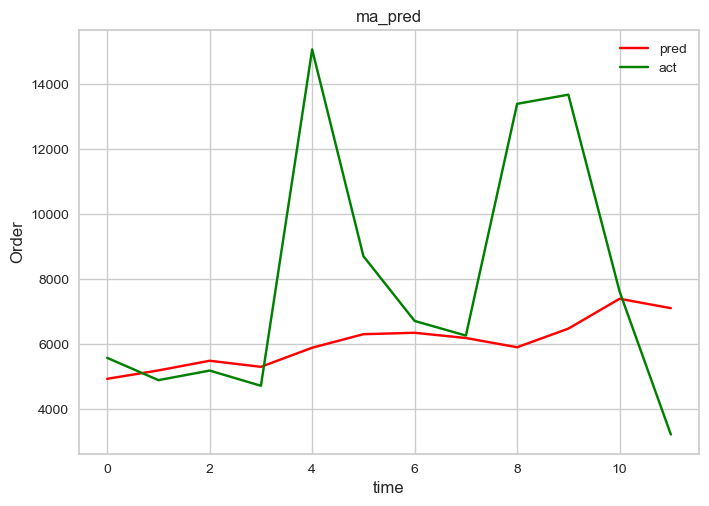

0.3018661469171053

In [6]:
ma_pred, ma_mape, ma_mape_real = ts.basic_model(pizza_X_train, pizza_y_train, pizza_X_val, pizza_y_val, pizza_X_test, pizza_y_test).ma(graph=True)
result_dic['ma'] = ma_mape
pred_dic['ma'] = ma_pred
ma_mape

In [7]:
# 전처리 순서 
# 먼저 train, val, test를 나누고 
pizza = pd.DataFrame(df[df['Product']=='frozen pizza'].groupby('Date')['Order'].sum())
pizza = pizza.resample('W-MON').sum()

pizza_test = pd.DataFrame(df_test[df_test['Product']=='frozen pizza'].groupby('Date')['Order'].sum())
pizza_test = pizza_test.resample('W-MON').sum()

pizza_test_len = len(pizza_test)

pizza_train = ts.Zscore_outlier(pizza,'Order').update_values_by_index(update_type='min_max')
alpha = 0.84 
pizza_train['Order'] = pizza_train['Order'].ewm(alpha=alpha, adjust=False).mean()

pizza = pd.concat([pizza_train, pizza_test], axis=0)

pizza['y'] = 0
pizza['y'][:-2] = pizza['Order'][2:]

log_pizza = np.log1p(pizza)
log_pizza = ts.Derived_Variable(log_pizza,'Order').all_Variable()
log_pizza = log_pizza.dropna(axis=0)
pizza = log_pizza

last_pizza_train = pizza[:-pizza_test_len].reset_index(drop=True)
last_pizza_test = pizza[-pizza_test_len:][:-2].reset_index(drop=True)
last_pizza_X_train, last_pizza_y_train = last_pizza_train.drop(['y'], axis=1),pd.DataFrame(last_pizza_train['y'])
last_pizza_X_test, last_pizza_y_test = last_pizza_test.drop(['y'], axis=1),pd.DataFrame(last_pizza_test['y'])

# Assuming you have X_train, X_val, and X_test defined elsewhere
last_pizza_X_train, last_pizza_X_val, last_pizza_X_test = preprocess(last_pizza_X_train, last_pizza_X_train, last_pizza_X_test)
X_train = np.exp(last_pizza_X_train)
data = X_train['Order'].to_numpy() # X_train['Order'] data to NumPy 
sorted_data = np.sort(data) # sort data 
a = abs(np.percentile(sorted_data, 50))  # median

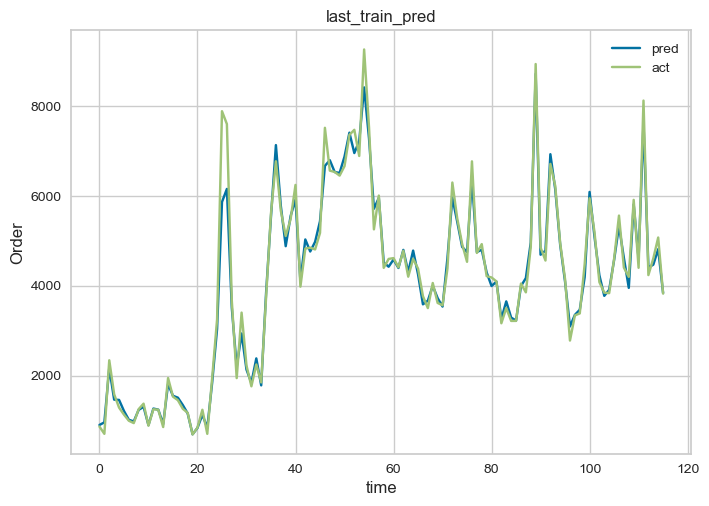

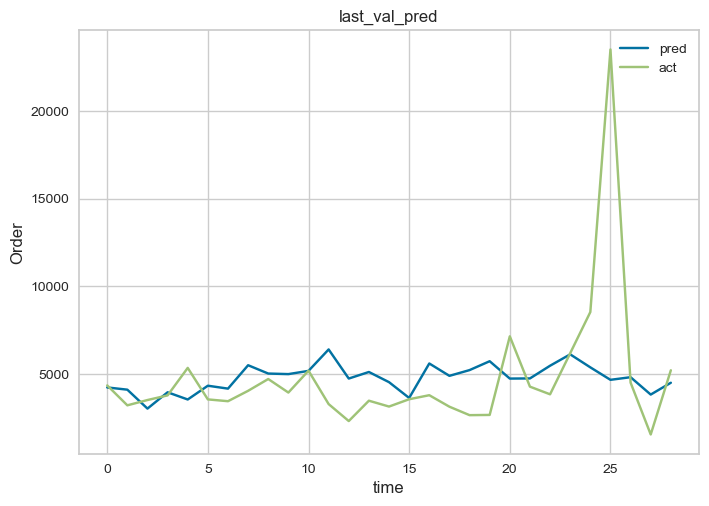

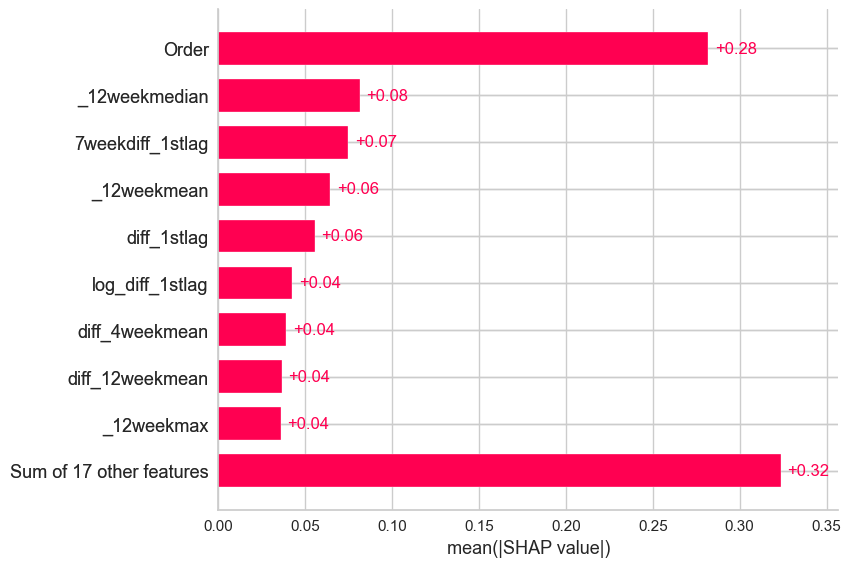

0.04504357235157968 0.4046923720519045


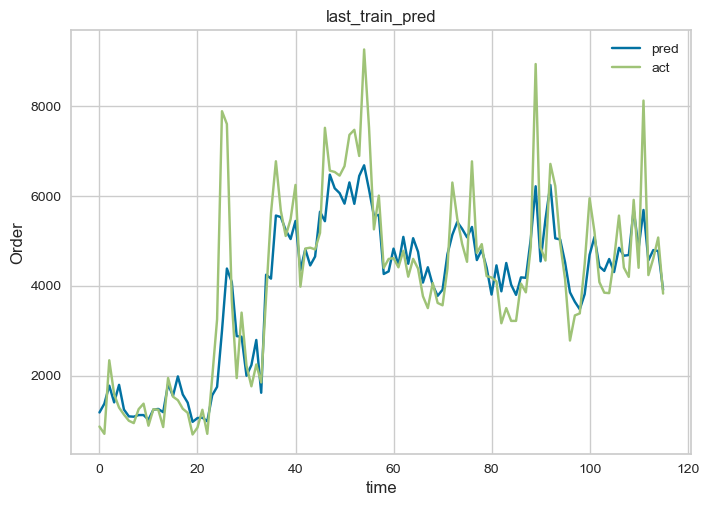

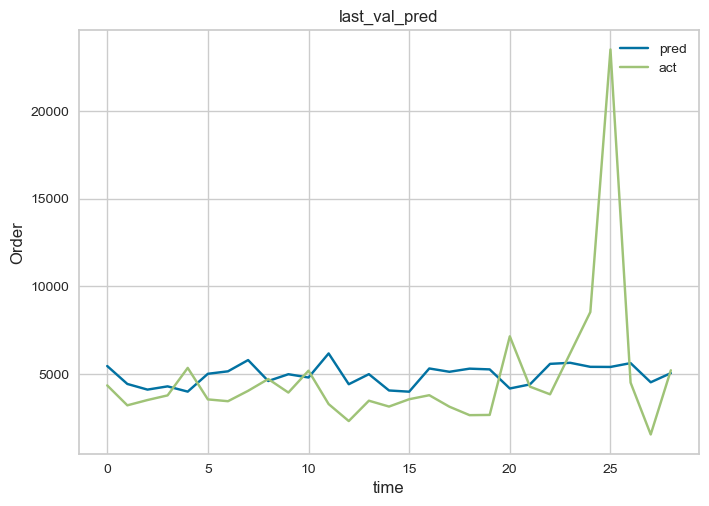

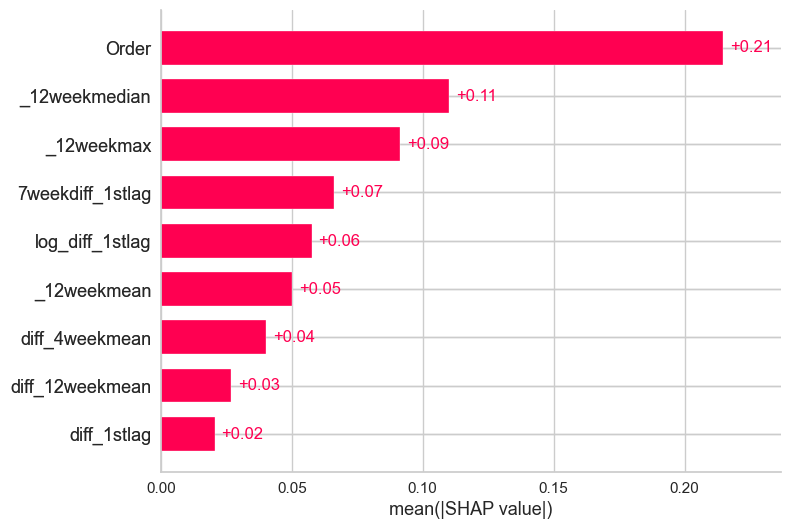

0.1505489980511912 0.44246277527850214


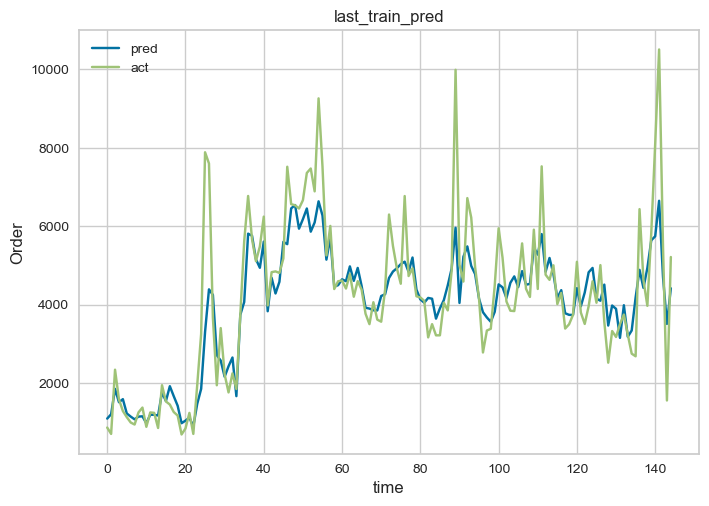

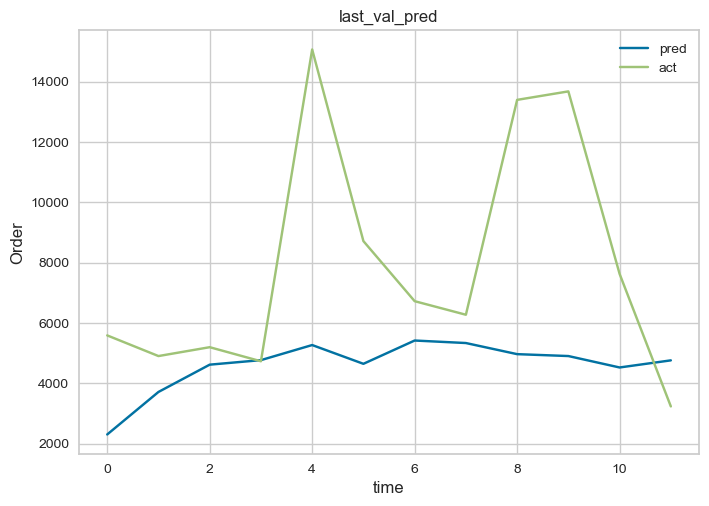

0.15438739521241154 0.38015768037104336


In [9]:
# lgbm_sort
y_train_pred, mape_train, y_val_pred, mape_val, top_9_feature_importance, best_model = ts.basic_model(pizza_X_train, pizza_y_train, pizza_X_val, pizza_y_val, pizza_X_test, pizza_y_test, pizza_X_train['Order']).lgbm(log=True,cross_val='sort')
print(mape_train, mape_val)
y_train_pred, mape_train, y_val_pred, mape_val, top_9_feature_importance, best_model = ts.basic_model(pizza_X_train[top_9_feature_importance], pizza_y_train, pizza_X_val[top_9_feature_importance], pizza_y_val, pizza_X_test[top_9_feature_importance], pizza_y_test, pizza_X_train['Order']).lgbm(log=True,cross_val='sort')
print(mape_train, mape_val)
y_train_pred, mape_train, y_val_pred, mape_val = ts.basic_model(last_pizza_X_train[top_9_feature_importance], last_pizza_y_train, last_pizza_X_test[top_9_feature_importance], pizza_y_test).last_train(best_model, a)
print(mape_train, mape_val)

result_dic['lgbm_sort'] = mape_val
pred_dic['lgbm_sort'] = y_val_pred
best_model_dic['lgbm_sort'] = best_model

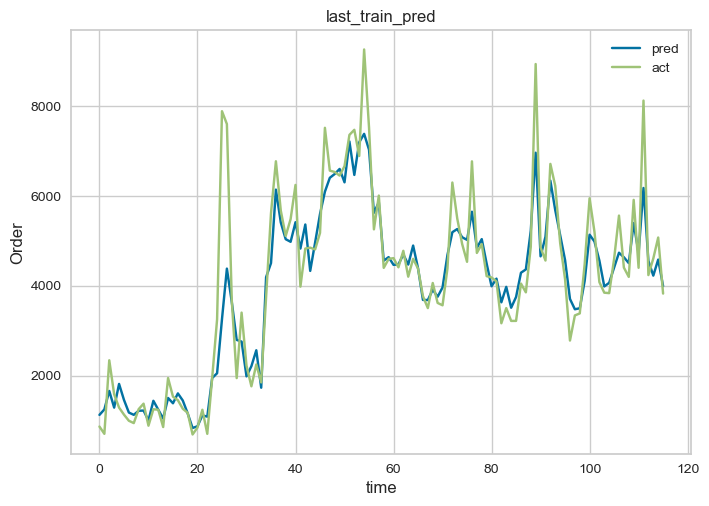

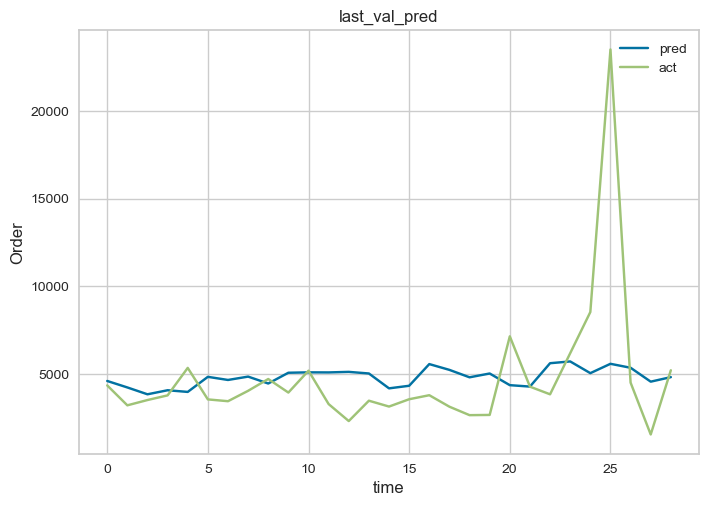

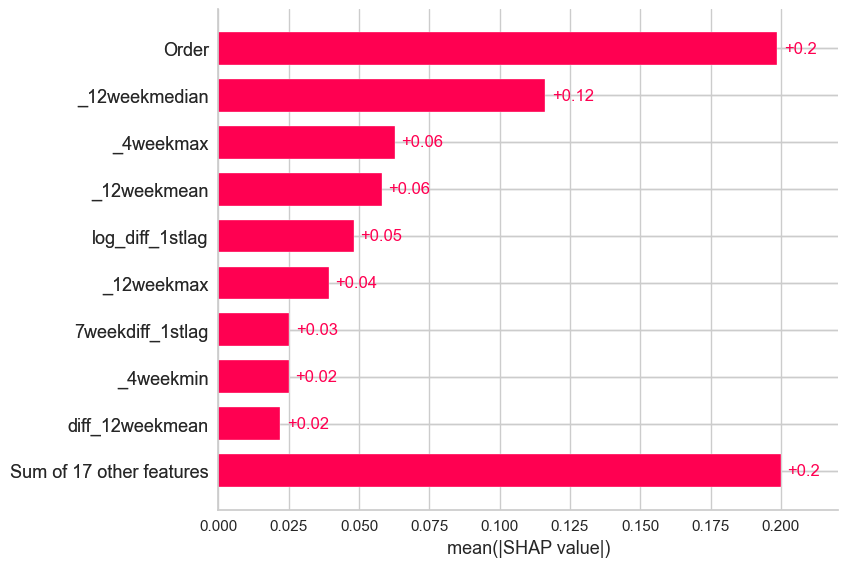

0.12110318474754421 0.4118515175018764


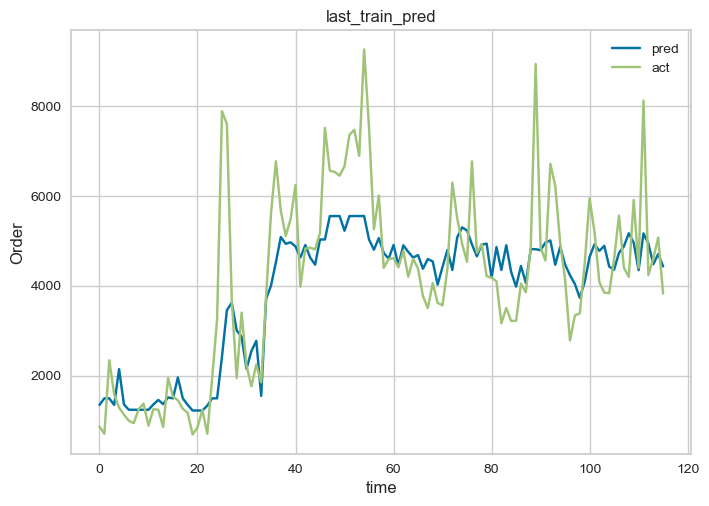

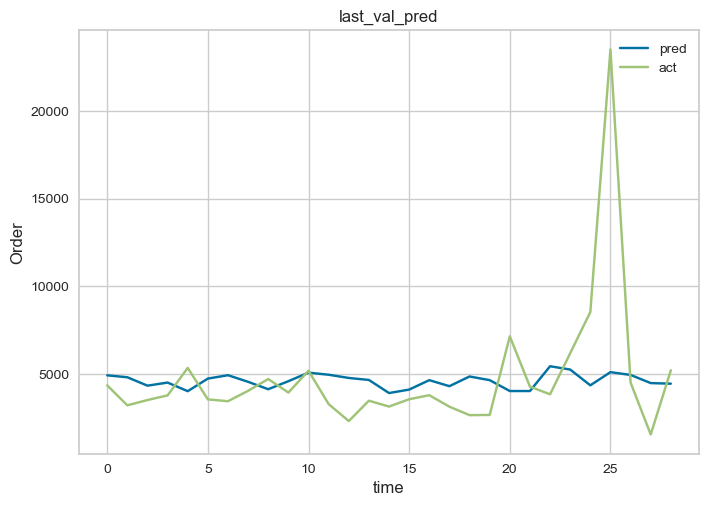

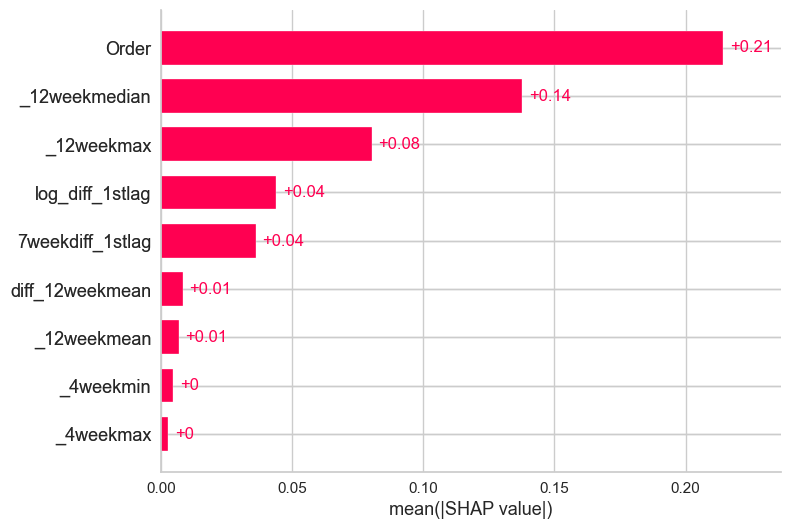

0.2102840669391588 0.39425835385975067


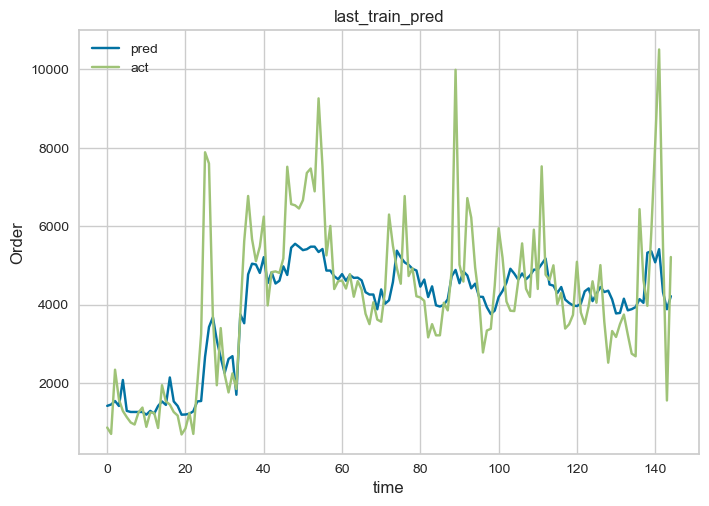

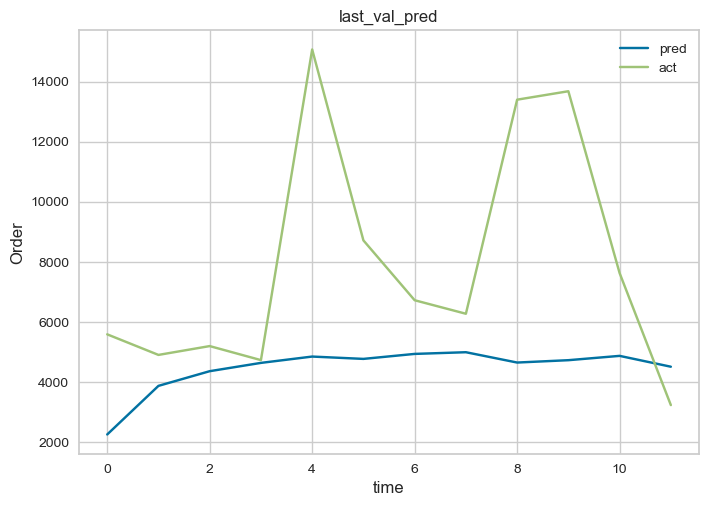

0.21730040917065324 0.3876525780062862


In [10]:
# lgbm,cross_val='accumulate'
y_train_pred, mape_train, y_val_pred, mape_val, top_9_feature_importance, best_model = ts.basic_model(pizza_X_train, pizza_y_train, pizza_X_val, pizza_y_val, pizza_X_test, pizza_y_test, pizza_X_train['Order']).lgbm(log=True,cross_val='accumulate')
print(mape_train, mape_val)
y_train_pred, mape_train, y_val_pred, mape_val, top_9_feature_importance, best_model = ts.basic_model(pizza_X_train[top_9_feature_importance], pizza_y_train, pizza_X_val[top_9_feature_importance], pizza_y_val, pizza_X_test[top_9_feature_importance], pizza_y_test, pizza_X_train['Order']).lgbm(log=True,cross_val='accumulate')
print(mape_train, mape_val)
y_train_pred, mape_train, y_val_pred, mape_val = ts.basic_model(last_pizza_X_train[top_9_feature_importance], last_pizza_y_train, last_pizza_X_test[top_9_feature_importance], pizza_y_test).last_train(best_model, a)
print(mape_train, mape_val)

result_dic['lgbm_accumulate'] = mape_val
pred_dic['lgbm_accumulate'] = y_val_pred
best_model_dic['lgbm_accumulate'] = best_model

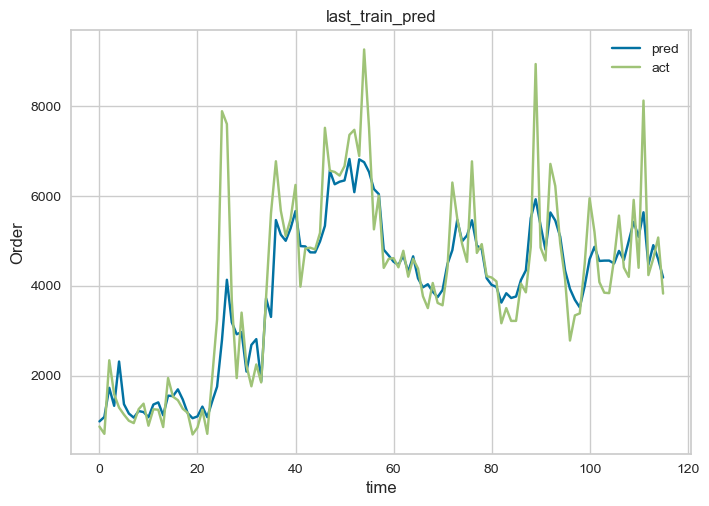

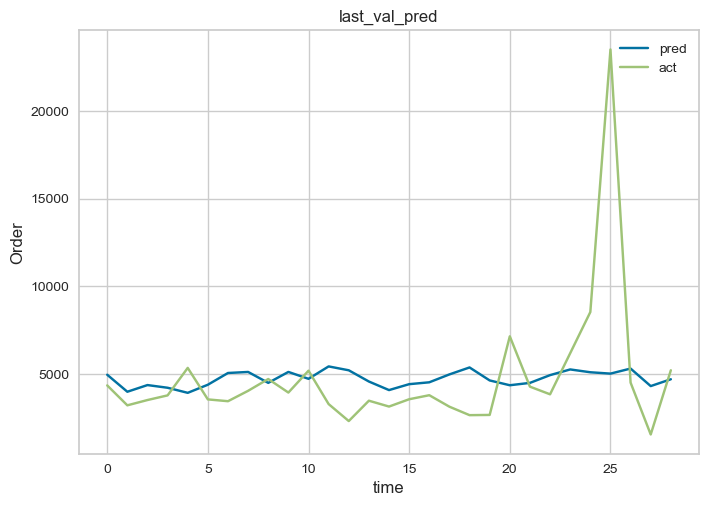

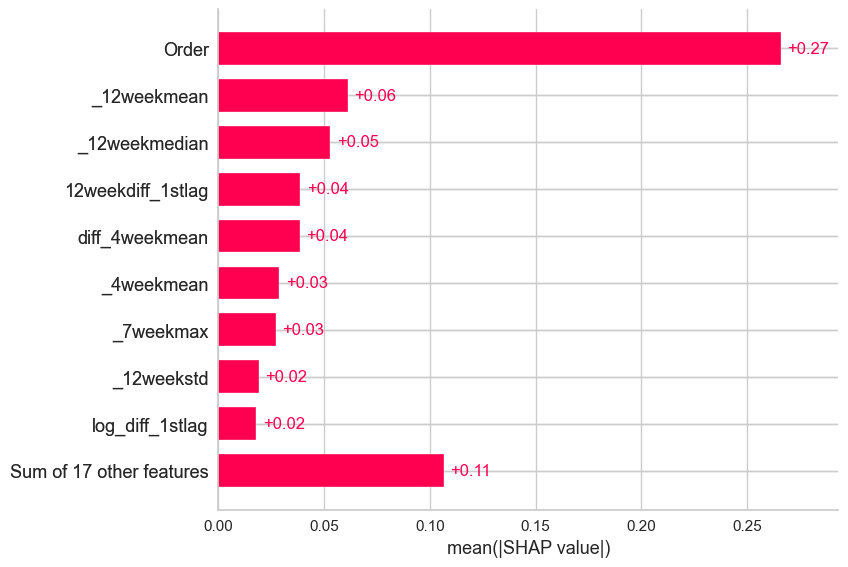

0.14530105290539688 0.4070259584210759


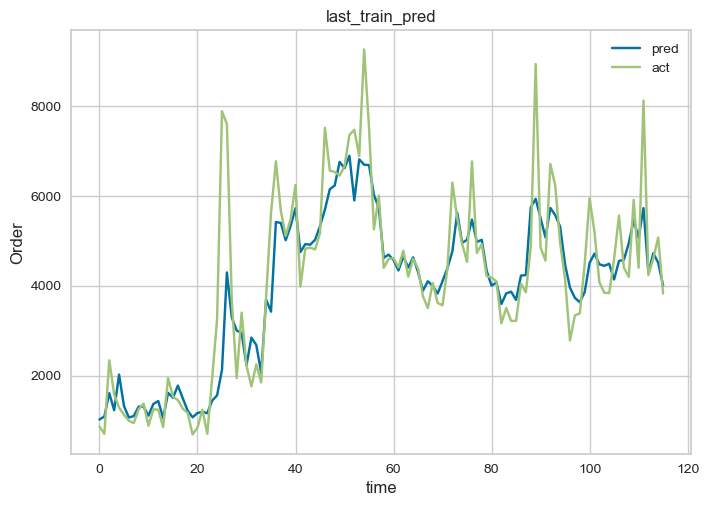

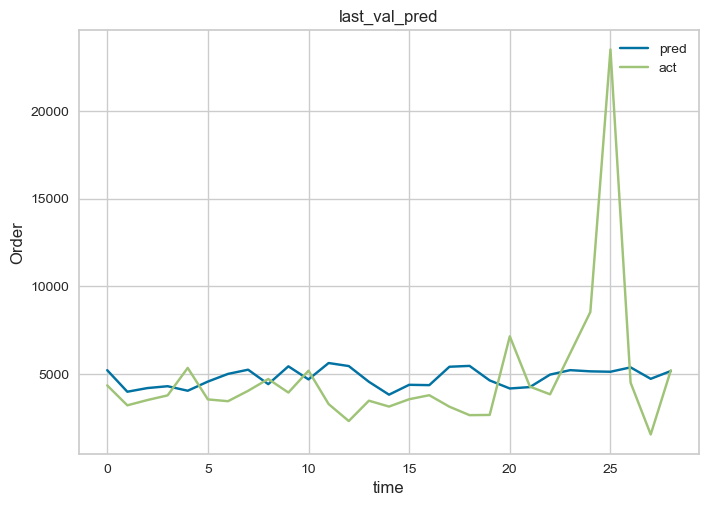

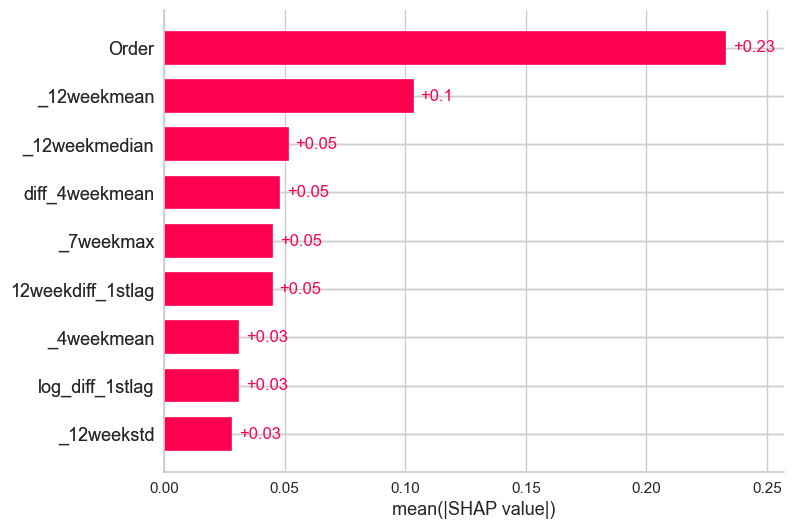

0.14911859741780403 0.42611534351377367


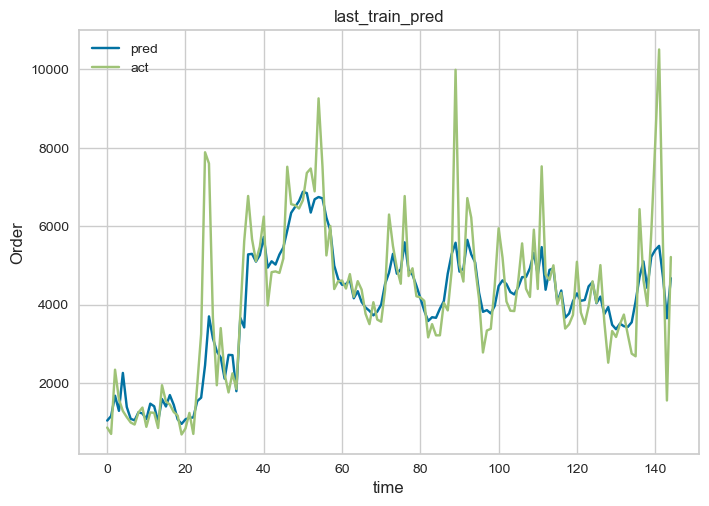

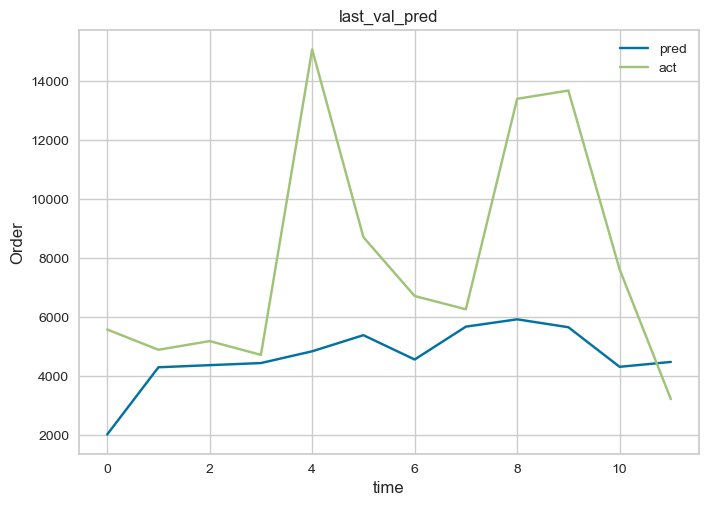

0.15793252463099164 0.3674569300641238


In [11]:
# rf,cross_val='sort'
y_train_pred, mape_train, y_val_pred, mape_val, top_9_feature_importance, best_model = ts.basic_model(pizza_X_train, pizza_y_train, pizza_X_val, pizza_y_val, pizza_X_test, pizza_y_test, pizza_X_train['Order']).rf(log=True,cross_val='sort')
print(mape_train, mape_val)
y_train_pred, mape_train, y_val_pred, mape_val, top_9_feature_importance, best_model = ts.basic_model(pizza_X_train[top_9_feature_importance], pizza_y_train, pizza_X_val[top_9_feature_importance], pizza_y_val, pizza_X_test[top_9_feature_importance], pizza_y_test, pizza_X_train['Order']).rf(log=True,cross_val='sort')
print(mape_train, mape_val)
y_train_pred, mape_train, y_val_pred, mape_val = ts.basic_model(last_pizza_X_train[top_9_feature_importance], last_pizza_y_train, last_pizza_X_test[top_9_feature_importance], pizza_y_test).last_train(best_model, a)
print(mape_train, mape_val)

result_dic['rf_sort'] = mape_val
pred_dic['rf_sort'] = y_val_pred
best_model_dic['rf_sort'] = best_model

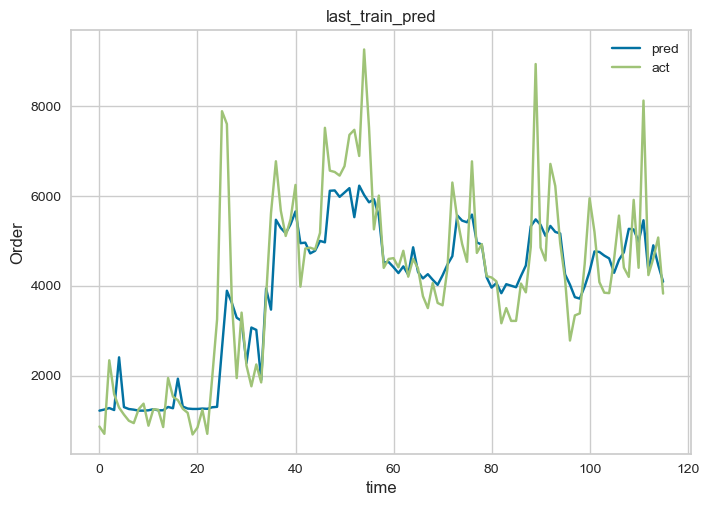

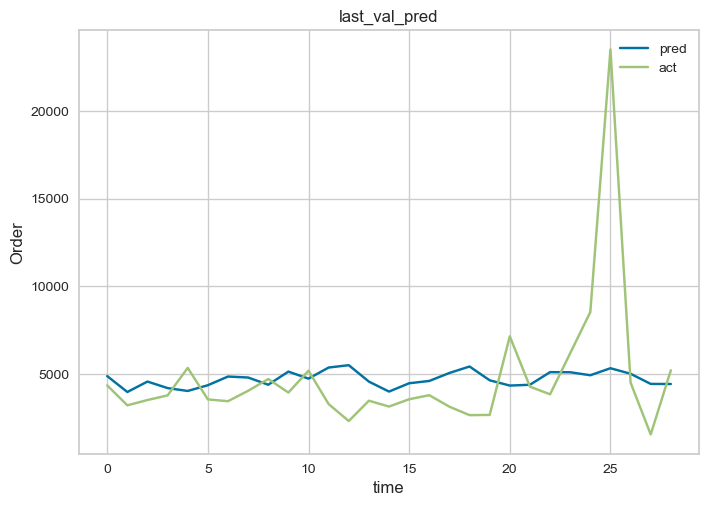

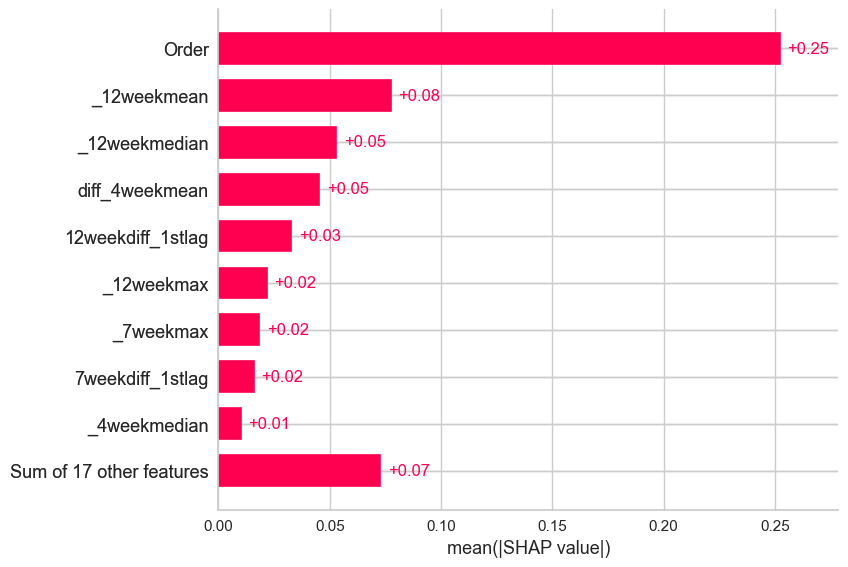

0.18694506692018933 0.4129429137505585


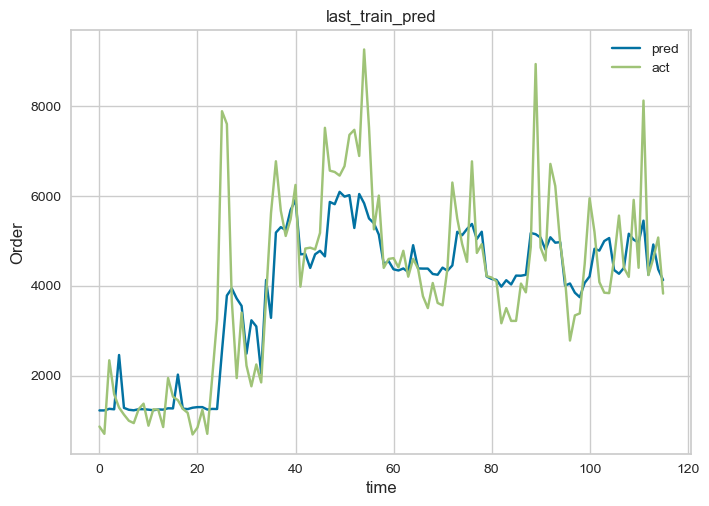

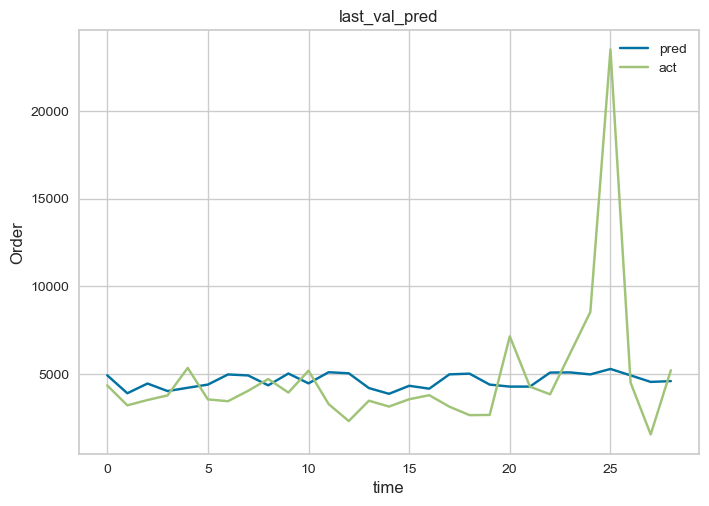

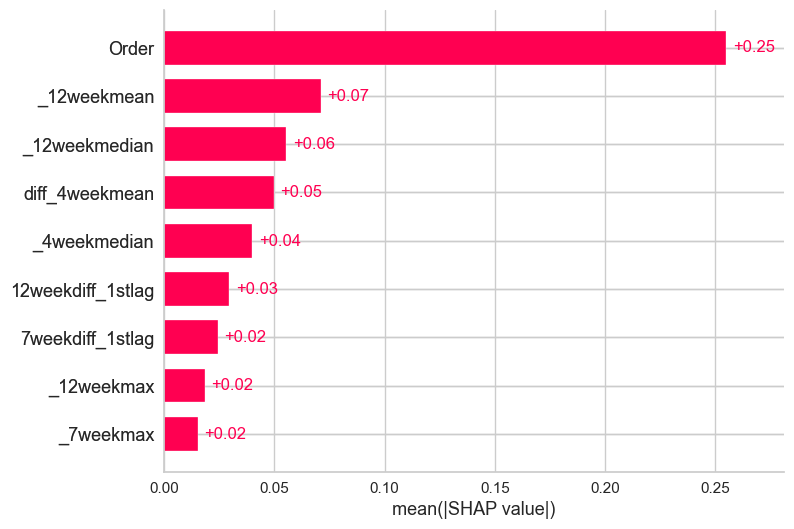

0.20116682526590926 0.38277365897228666


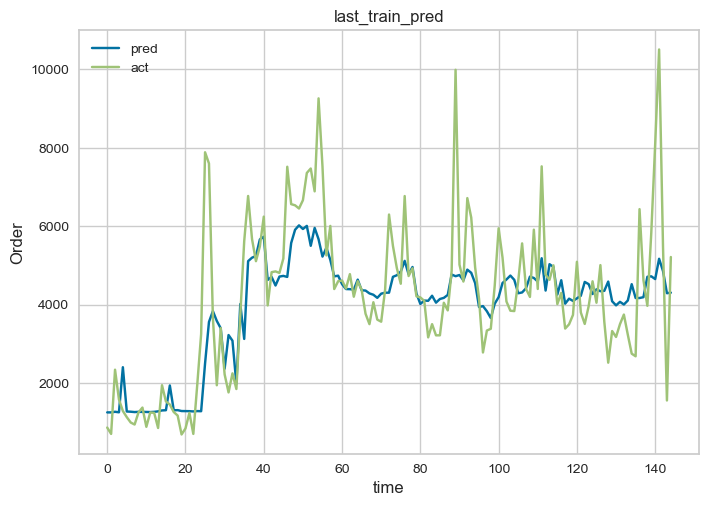

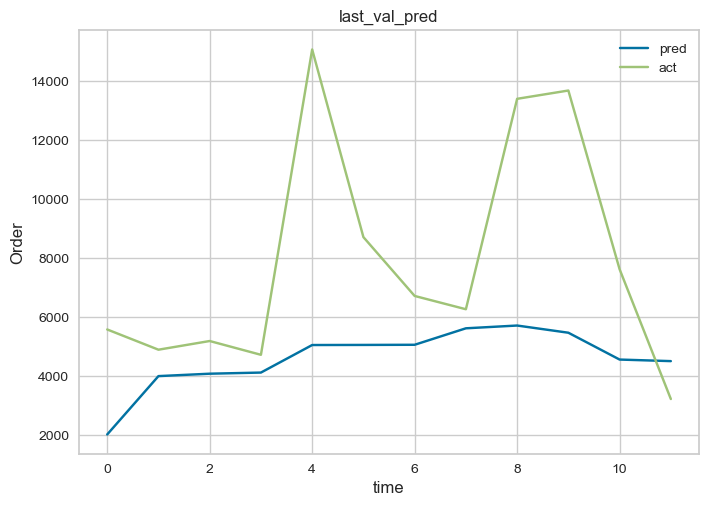

0.21846342856508139 0.38013194543093537


In [12]:
# rf,cross_val='accumulate'
y_train_pred, mape_train, y_val_pred, mape_val, top_9_feature_importance, best_model = ts.basic_model(pizza_X_train, pizza_y_train, pizza_X_val, pizza_y_val, pizza_X_test, pizza_y_test, pizza_X_train['Order']).rf(log=True,cross_val='accumulate')
print(mape_train, mape_val)
y_train_pred, mape_train, y_val_pred, mape_val, top_9_feature_importance, best_model = ts.basic_model(pizza_X_train[top_9_feature_importance], pizza_y_train, pizza_X_val[top_9_feature_importance], pizza_y_val, pizza_X_test[top_9_feature_importance], pizza_y_test, pizza_X_train['Order']).rf(log=True,cross_val='accumulate')
print(mape_train, mape_val)
y_train_pred, mape_train, y_val_pred, mape_val = ts.basic_model(last_pizza_X_train[top_9_feature_importance], last_pizza_y_train, last_pizza_X_test[top_9_feature_importance], pizza_y_test).last_train(best_model, a)
print(mape_train, mape_val)

result_dic['rf_accumulate'] = mape_val
pred_dic['rf_accumulate'] = y_val_pred
best_model_dic['rf_accumulate'] = best_model

[11:27:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:1517: Empty dataset at worker: 0
[11:27:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:1517: Empty dataset at worker: 0
[11:27:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:1517: Empty dataset at worker: 0
[11:27:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:1517: Empty dataset at worker: 0
[11:27:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:1517: Empty dataset at worker: 0
[11:27:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group

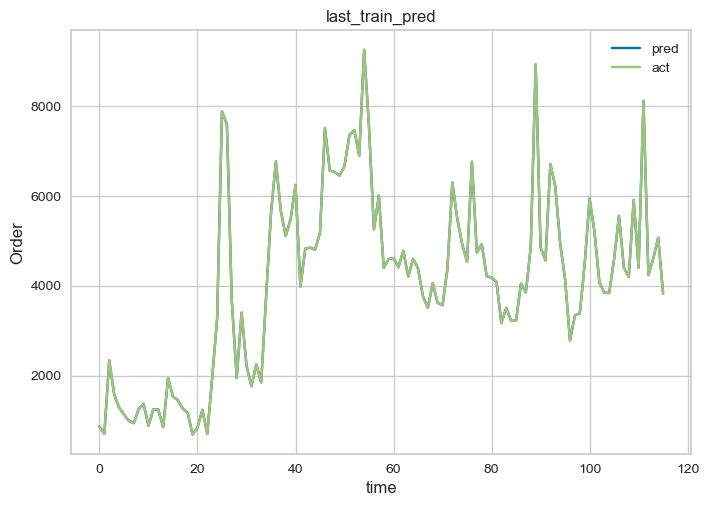

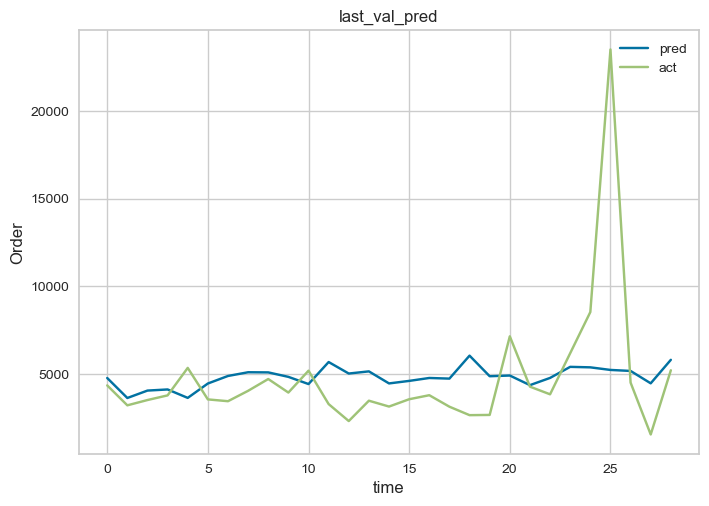

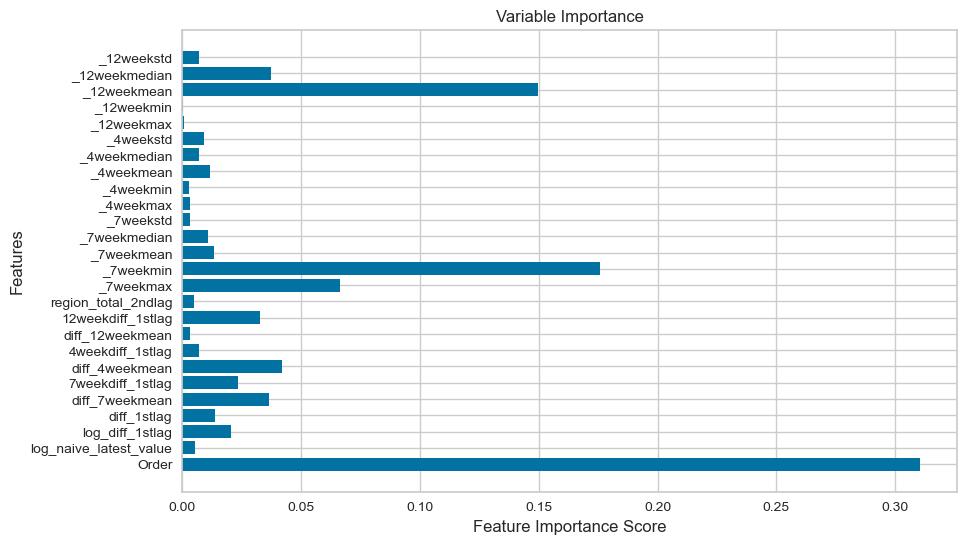

0.0005671167767133643 0.417769741522772
[11:27:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:1517: Empty dataset at worker: 0
[11:27:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:1517: Empty dataset at worker: 0
[11:27:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:1517: Empty dataset at worker: 0
[11:27:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:1517: Empty dataset at worker: 0
[11:27:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:1517: Empty dataset at worker: 0
[11:28:02] WARNING: C:\buildkite-agent\builds

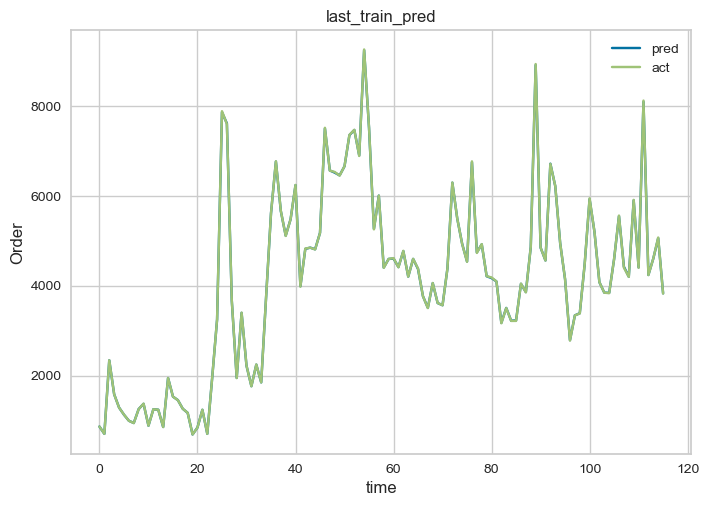

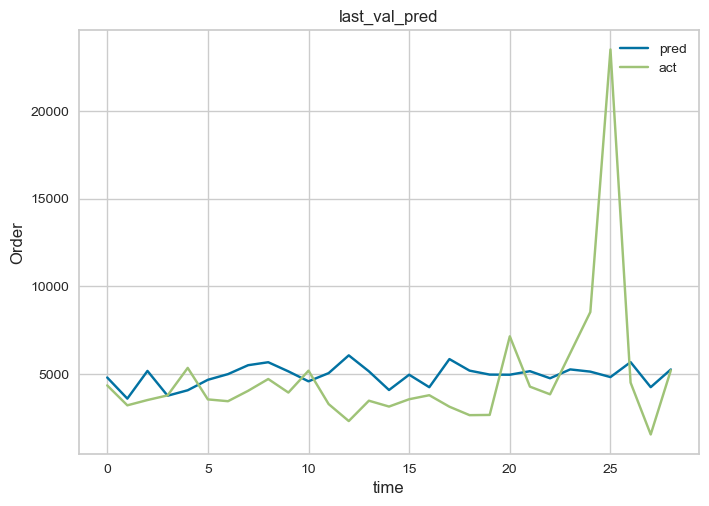

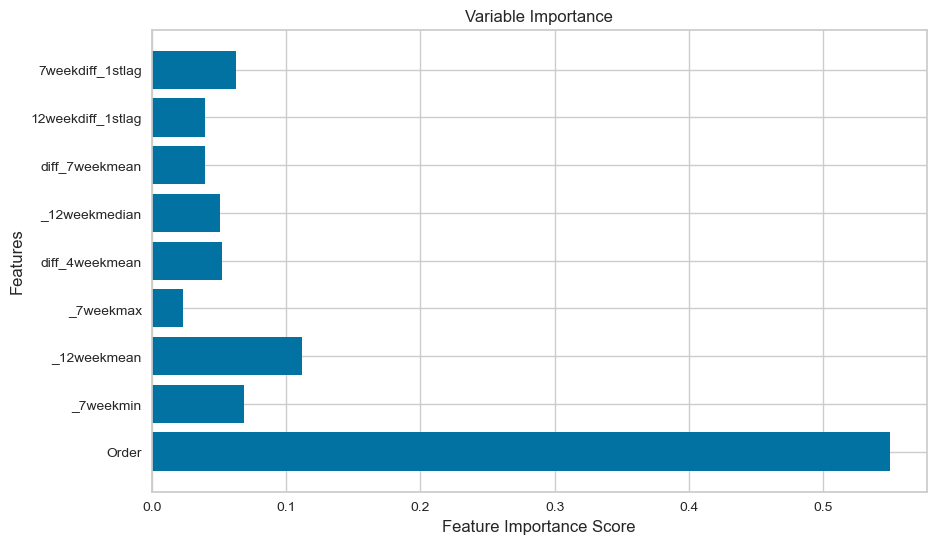

0.001169473425101703 0.444721403429284


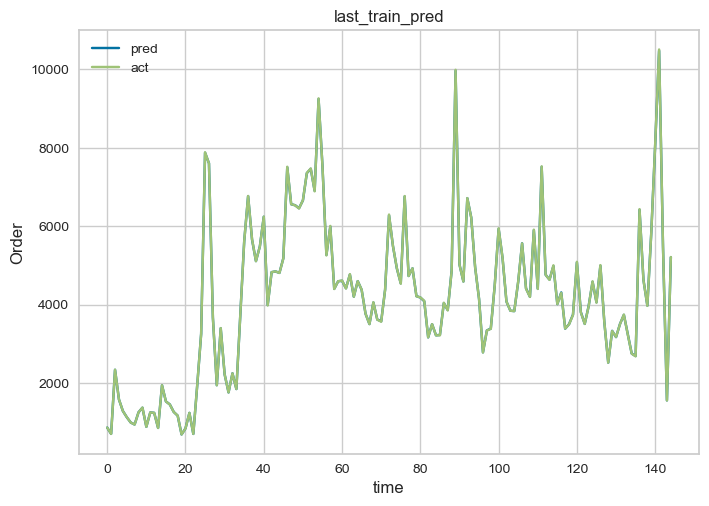

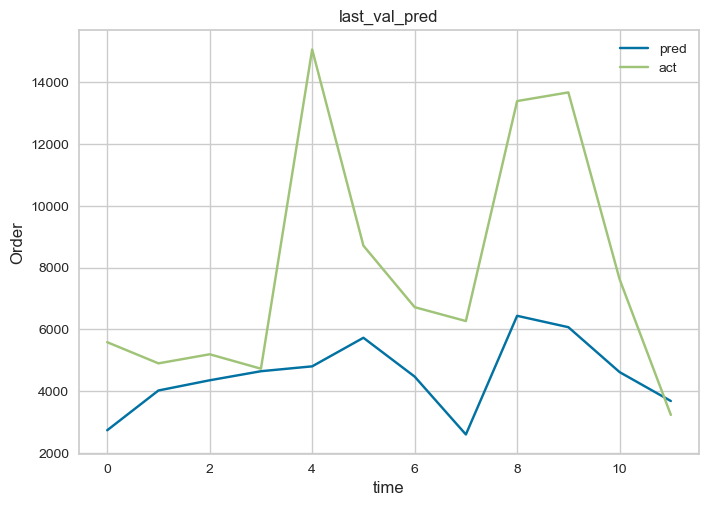

0.001197334679736999 0.3684618120199679


In [13]:
# xgb,cross_val='sort'
y_train_pred, mape_train, y_val_pred, mape_val, top_9_feature_importance, best_model = ts.basic_model(pizza_X_train, pizza_y_train, pizza_X_val, pizza_y_val, pizza_X_test, pizza_y_test, pizza_X_train['Order']).xgb(log=True,cross_val='sort')
print(mape_train, mape_val)
y_train_pred, mape_train, y_val_pred, mape_val, top_9_feature_importance, best_model = ts.basic_model(pizza_X_train[top_9_feature_importance], pizza_y_train, pizza_X_val[top_9_feature_importance], pizza_y_val, pizza_X_test[top_9_feature_importance], pizza_y_test, pizza_X_train['Order']).xgb(log=True,cross_val='sort')
print(mape_train, mape_val)
y_train_pred, mape_train, y_val_pred, mape_val = ts.basic_model(last_pizza_X_train[top_9_feature_importance], last_pizza_y_train, last_pizza_X_test[top_9_feature_importance], pizza_y_test).last_train(best_model, a)
print(mape_train, mape_val)

result_dic['xgb_sort'] = mape_val
pred_dic['xgb_sort'] = y_val_pred
best_model_dic['xgb_sort'] = best_model

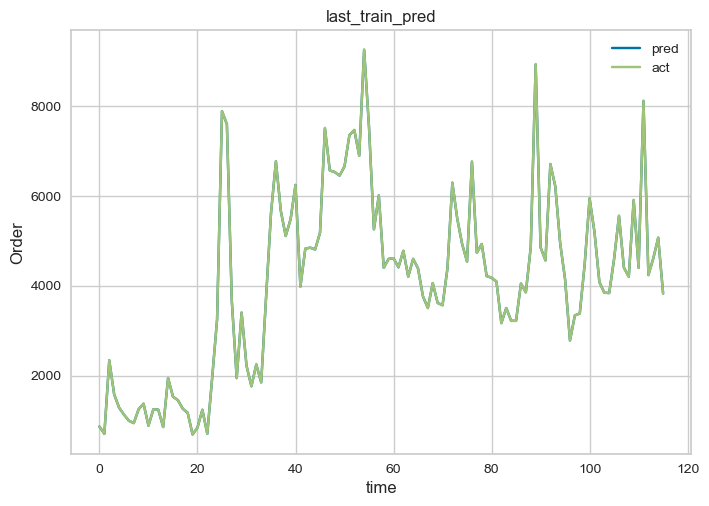

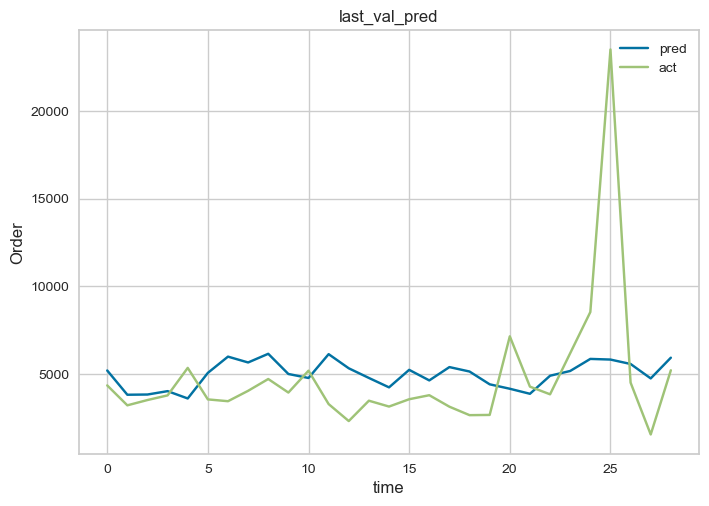

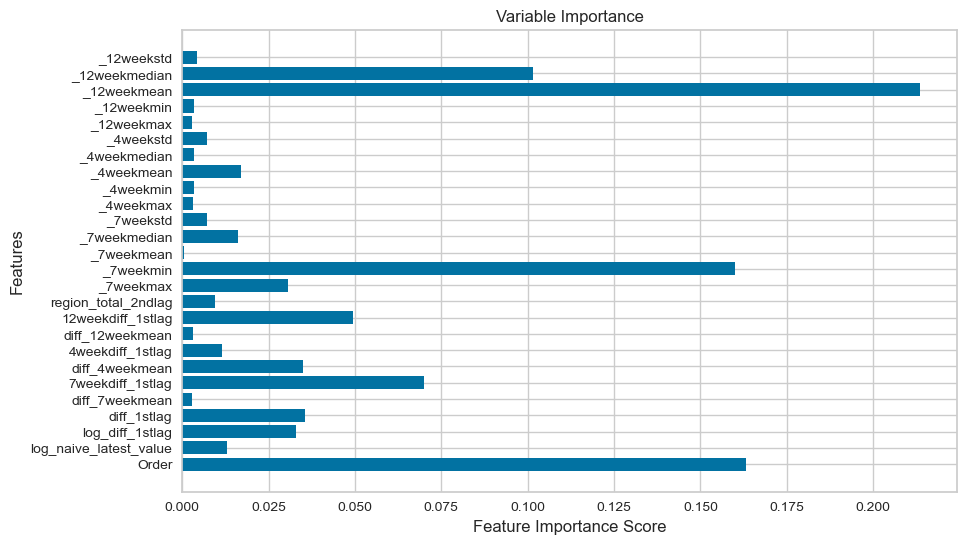

0.000491775849914781 0.46197570874317867


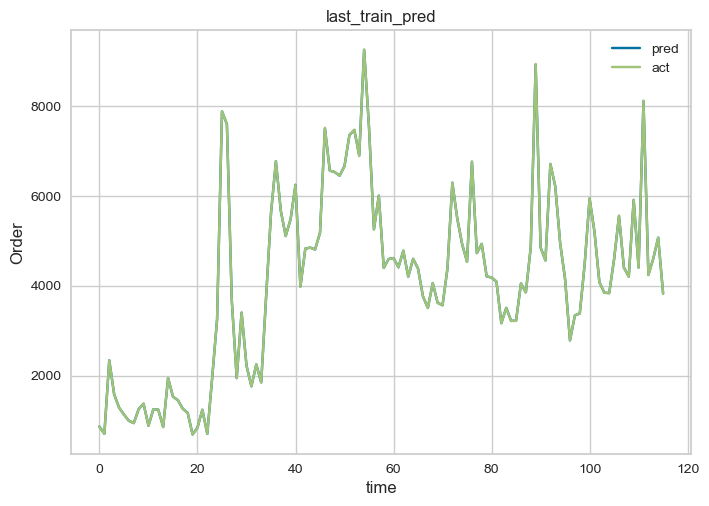

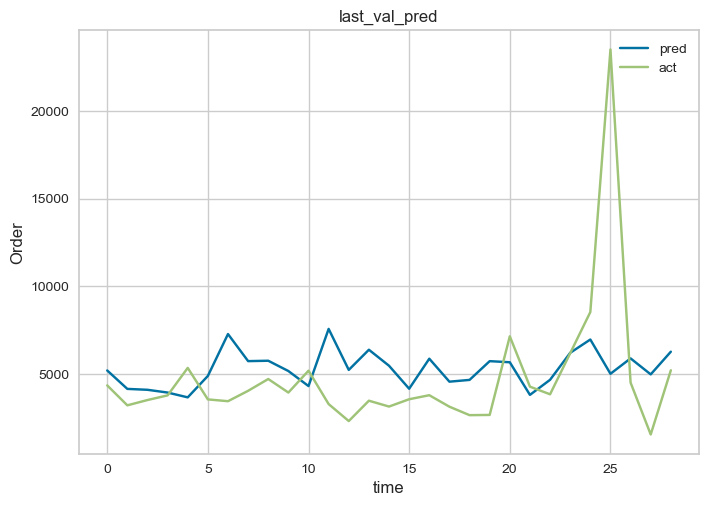

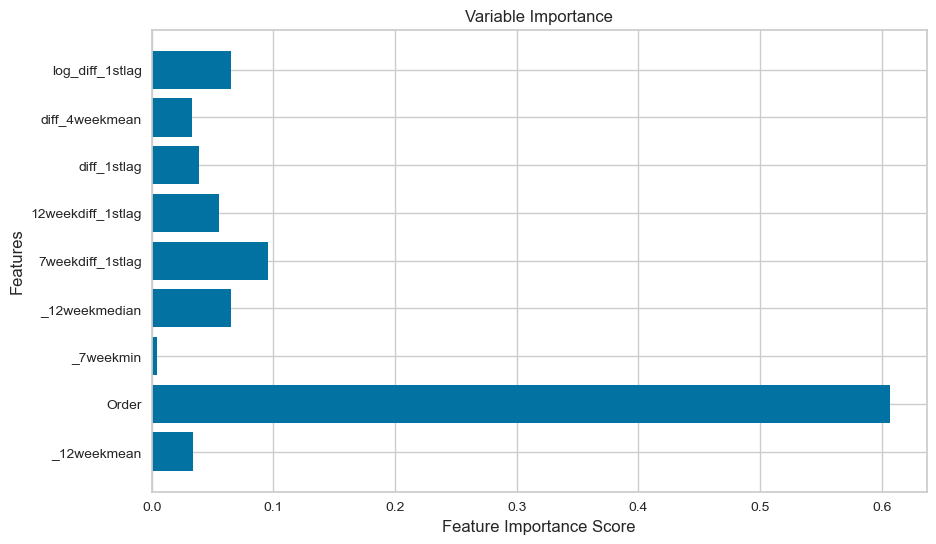

0.0005462414953232926 0.5183100472667002


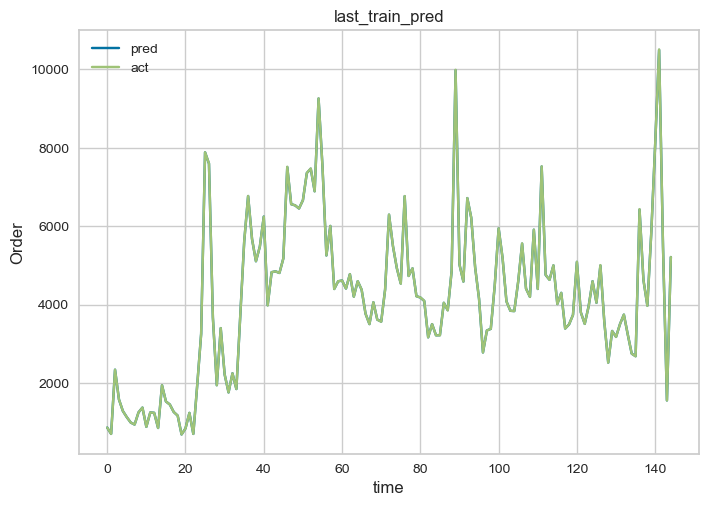

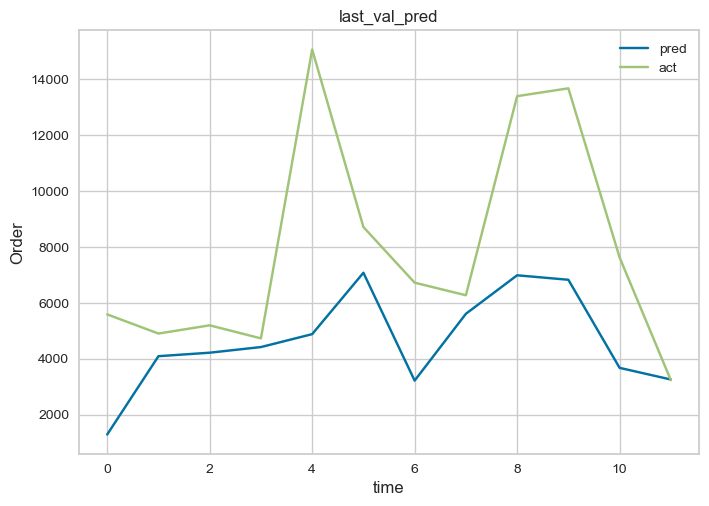

0.0004979090850088319 0.3487602028054118


In [14]:
# xgb,cross_val='accumulate'
y_train_pred, mape_train, y_val_pred, mape_val, top_9_feature_importance, best_model = ts.basic_model(pizza_X_train, pizza_y_train, pizza_X_val, pizza_y_val, pizza_X_test, pizza_y_test, pizza_X_train['Order']).xgb(log=True,cross_val='accumulate')
print(mape_train, mape_val)
y_train_pred, mape_train, y_val_pred, mape_val, top_9_feature_importance, best_model = ts.basic_model(pizza_X_train[top_9_feature_importance], pizza_y_train, pizza_X_val[top_9_feature_importance], pizza_y_val, pizza_X_test[top_9_feature_importance], pizza_y_test, pizza_X_train['Order']).xgb(log=True,cross_val='accumulate')
print(mape_train, mape_val)
y_train_pred, mape_train, y_val_pred, mape_val = ts.basic_model(last_pizza_X_train[top_9_feature_importance], last_pizza_y_train, last_pizza_X_test[top_9_feature_importance], pizza_y_test).last_train(best_model, a)
print(mape_train, mape_val)

result_dic['xgb_accumulate'] = mape_val
pred_dic['xgb_accumulate'] = y_val_pred
best_model_dic['xgb_accumulate'] = best_model

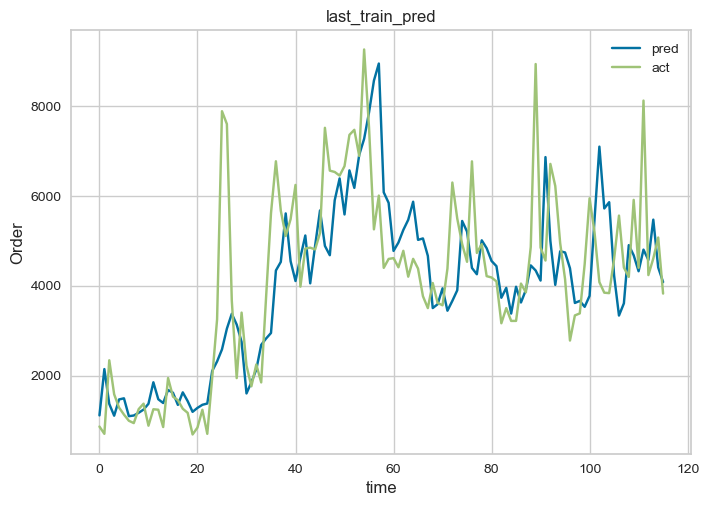

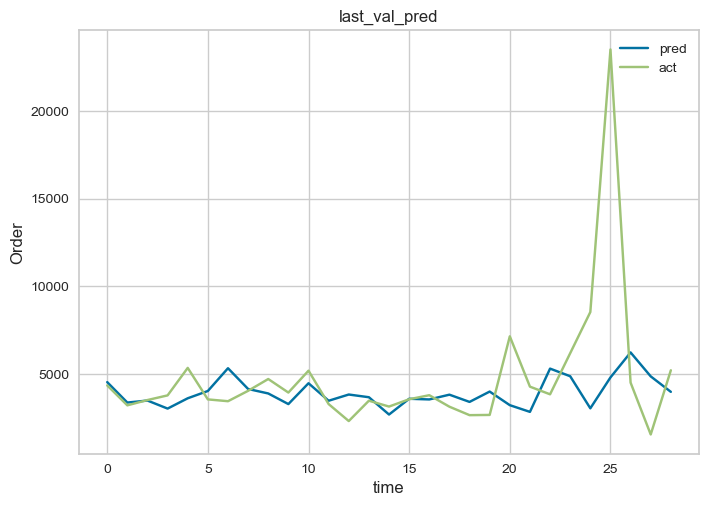

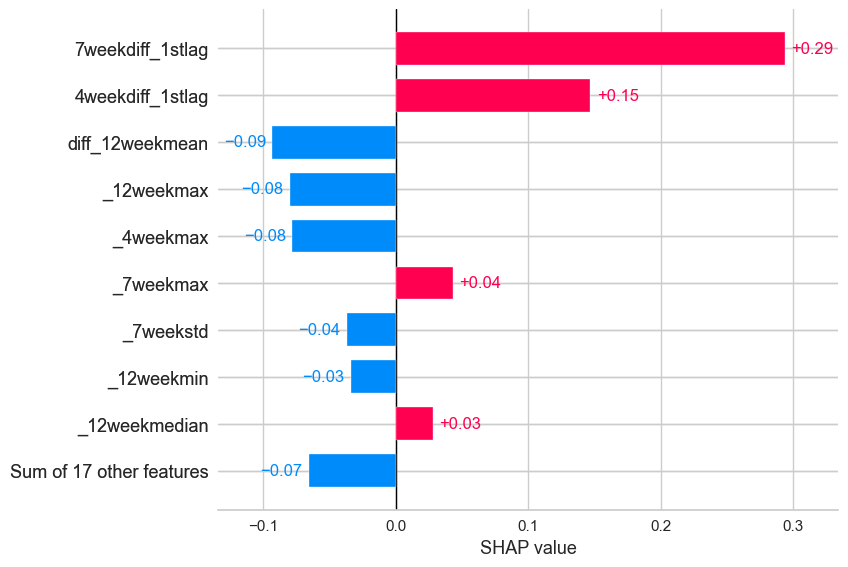

0.2544908177871569 0.3257920379141007


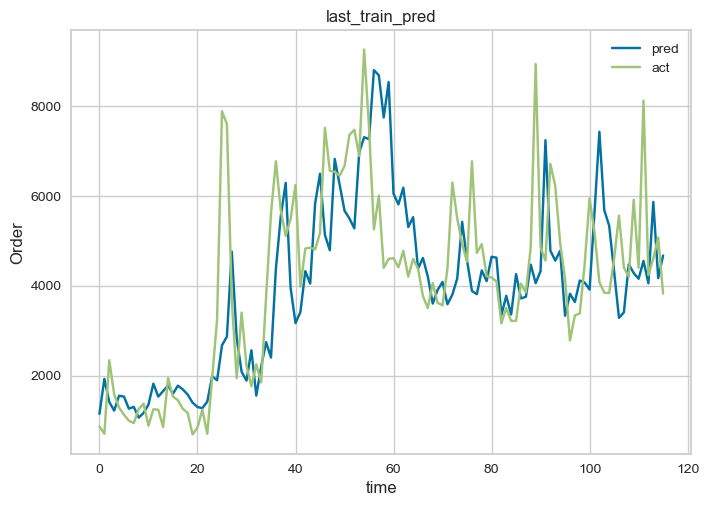

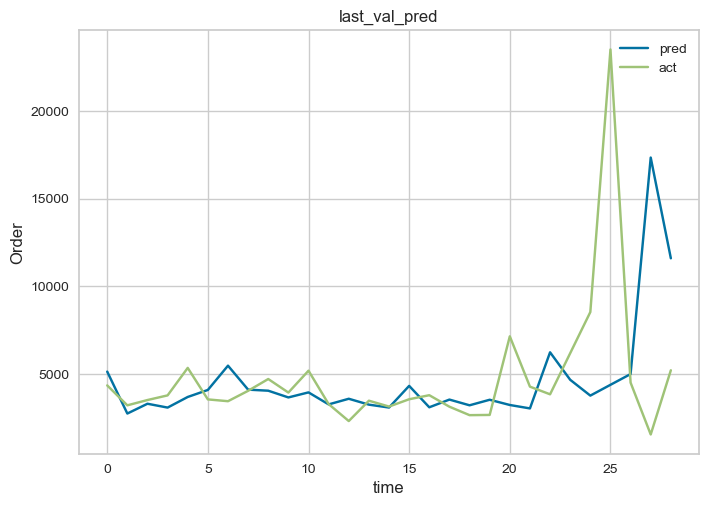

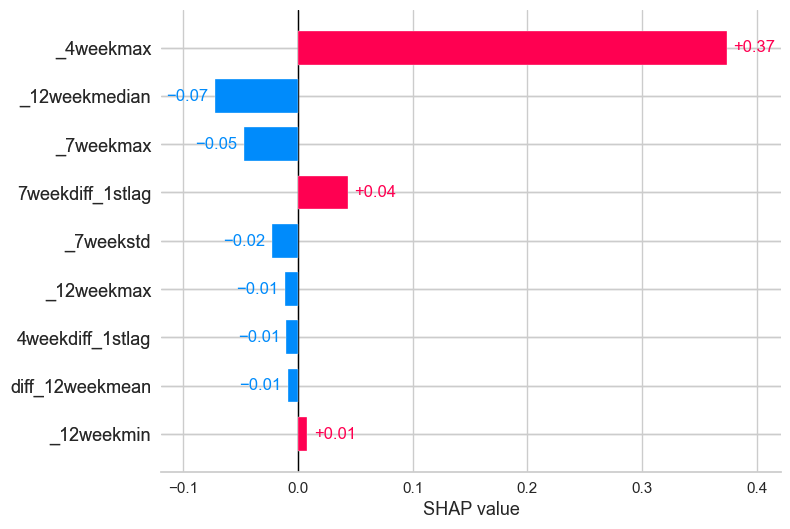

0.2876019987993968 0.6318447077562349


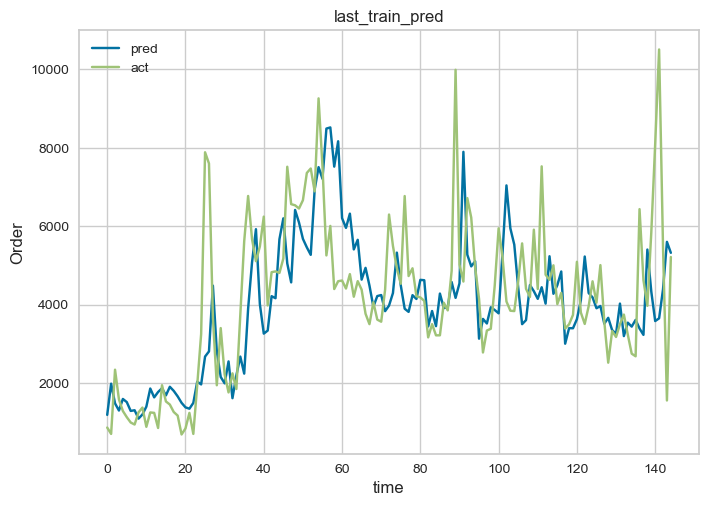

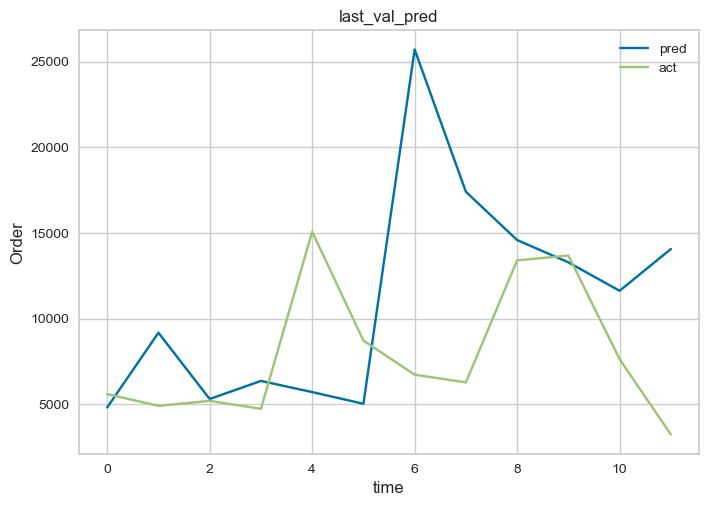

0.29324162827807104 0.9174780837818027


In [15]:
# ridge,cross_val='accumulate'
y_train_pred, mape_train, y_val_pred, mape_val, top_9_feature_importance, best_model = ts.basic_model(pizza_X_train, pizza_y_train, pizza_X_val, pizza_y_val, pizza_X_test, pizza_y_test, pizza_X_train['Order']).ridge(log=True,cross_val='accumulate')
print(mape_train, mape_val)
y_train_pred, mape_train, y_val_pred, mape_val, top_9_feature_importance, best_model = ts.basic_model(pizza_X_train[top_9_feature_importance], pizza_y_train, pizza_X_val[top_9_feature_importance], pizza_y_val, pizza_X_test[top_9_feature_importance], pizza_y_test, pizza_X_train['Order']).ridge(log=True,cross_val='accumulate')
print(mape_train, mape_val)
y_train_pred, mape_train, y_val_pred, mape_val = ts.basic_model(last_pizza_X_train[top_9_feature_importance], last_pizza_y_train, last_pizza_X_test[top_9_feature_importance], pizza_y_test).last_train(best_model, a)
print(mape_train, mape_val)

result_dic['ridge_accumulate'] = mape_val
pred_dic['ridge_accumulate'] = y_val_pred
best_model_dic['ridge_accumulate'] = best_model

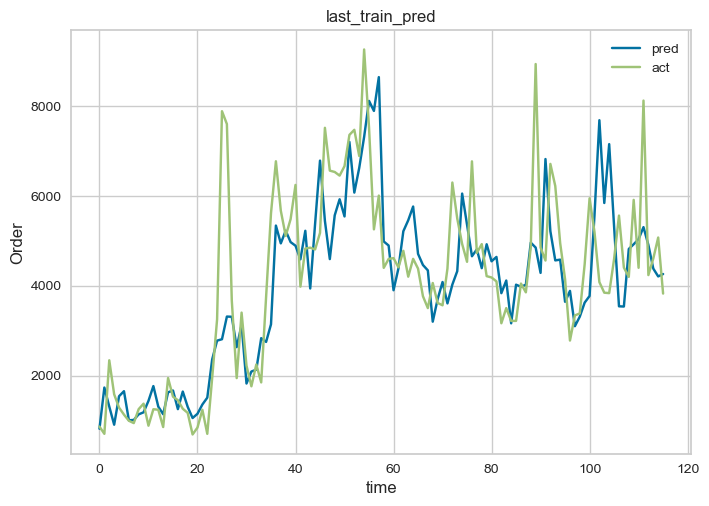

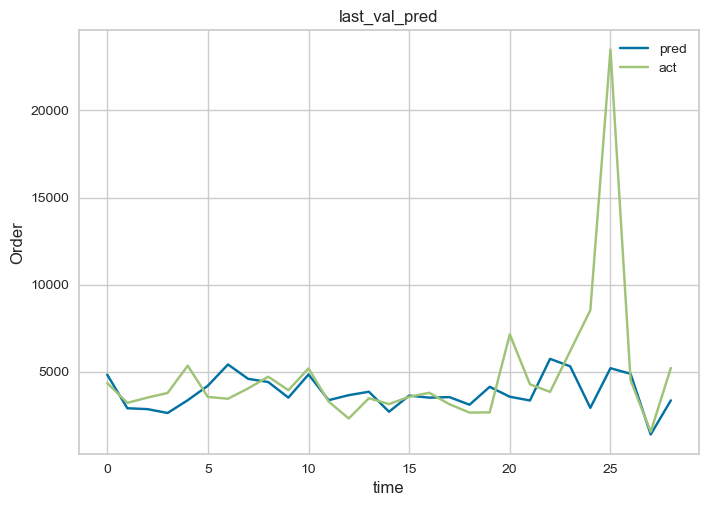

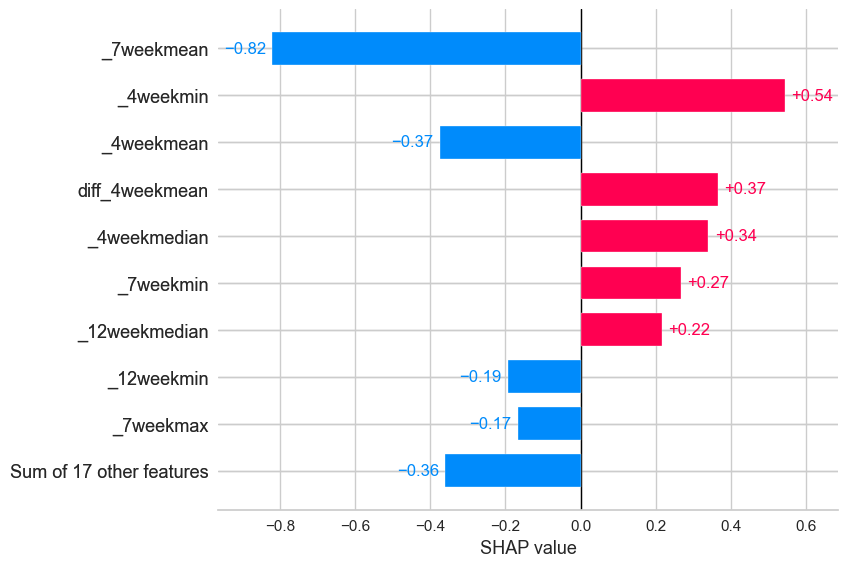

0.23462343680788014 0.2520978171921228


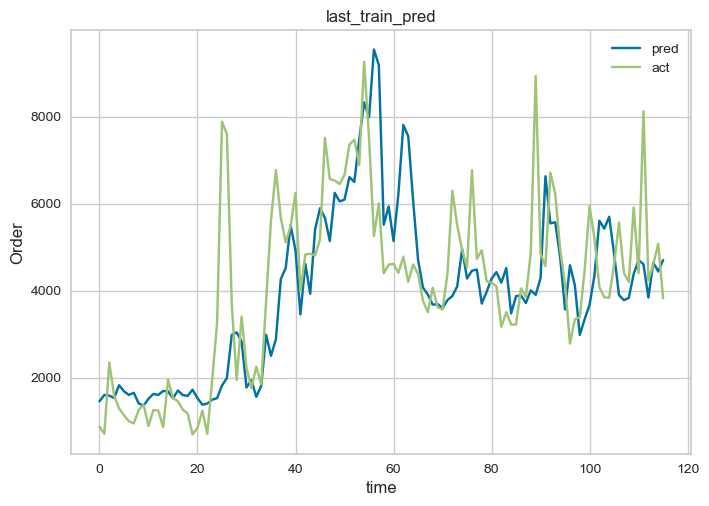

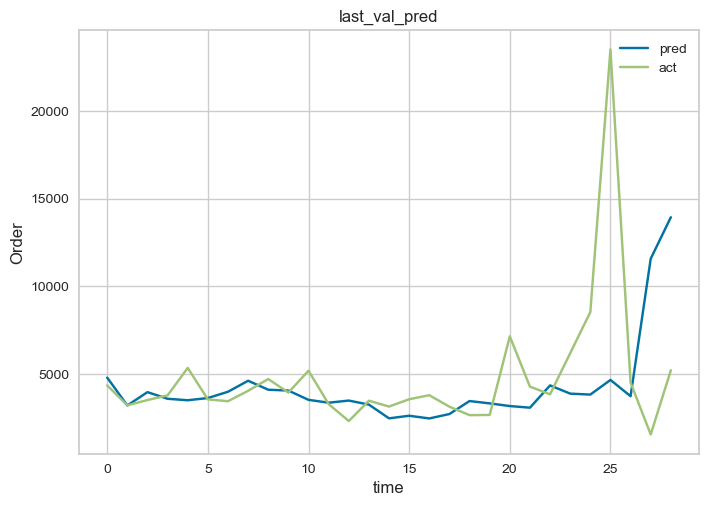

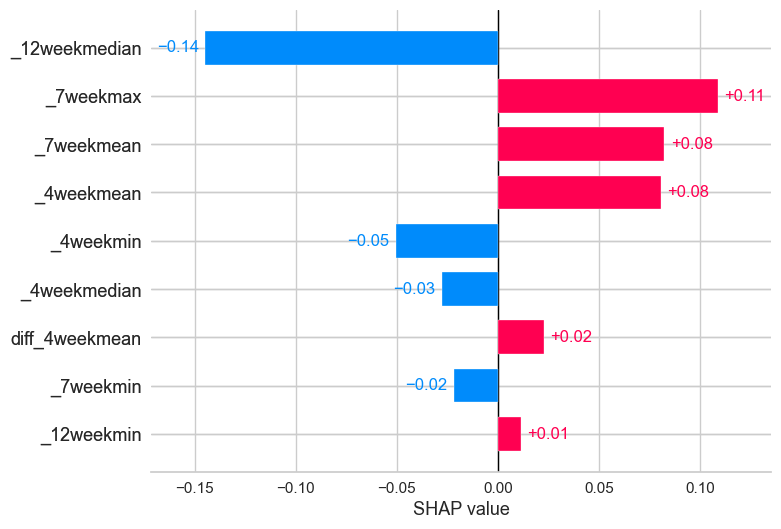

0.28115651203509867 0.4998556883053227


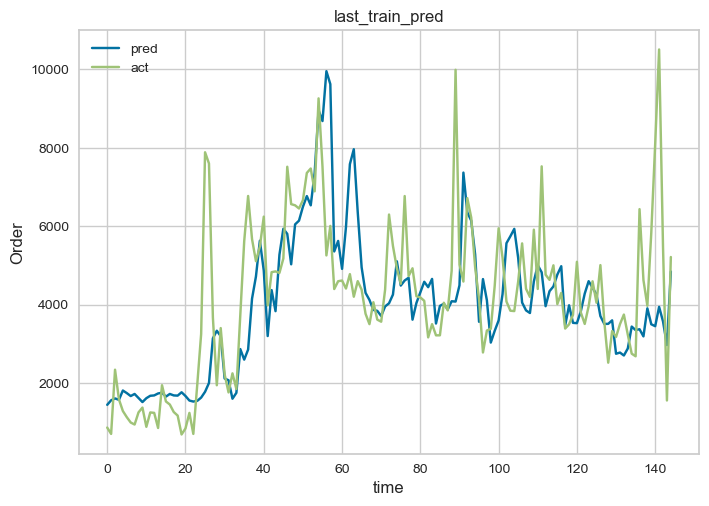

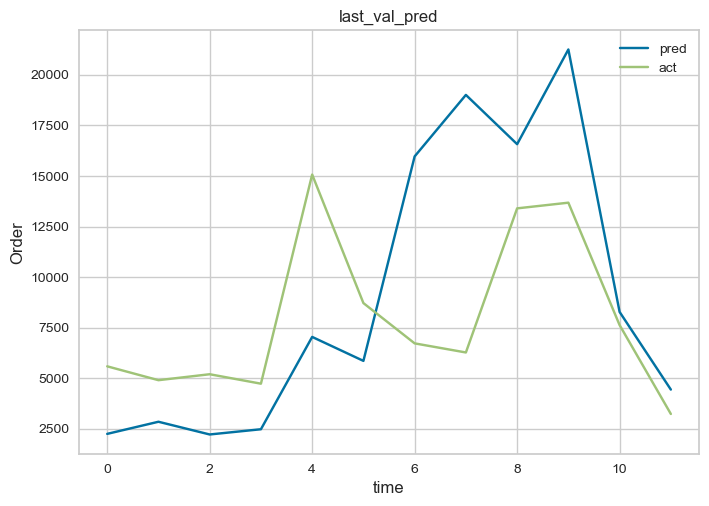

0.28472571995972856 0.6317786032461072


In [16]:
# ridge,cross_val='sort'
y_train_pred, mape_train, y_val_pred, mape_val, top_9_feature_importance, best_model = ts.basic_model(pizza_X_train, pizza_y_train, pizza_X_val, pizza_y_val, pizza_X_test, pizza_y_test, pizza_X_train['Order']).ridge(log=True,cross_val='sort')
print(mape_train, mape_val)
y_train_pred, mape_train, y_val_pred, mape_val, top_9_feature_importance, best_model = ts.basic_model(pizza_X_train[top_9_feature_importance], pizza_y_train, pizza_X_val[top_9_feature_importance], pizza_y_val, pizza_X_test[top_9_feature_importance], pizza_y_test, pizza_X_train['Order']).ridge(log=True,cross_val='sort')
print(mape_train, mape_val)
y_train_pred, mape_train, y_val_pred, mape_val = ts.basic_model(last_pizza_X_train[top_9_feature_importance], last_pizza_y_train, last_pizza_X_test[top_9_feature_importance], pizza_y_test).last_train(best_model, a)
print(mape_train, mape_val)

result_dic['ridge_sort'] = mape_val
pred_dic['ridge_sort'] = y_val_pred
best_model_dic['ridge_sort'] = best_model

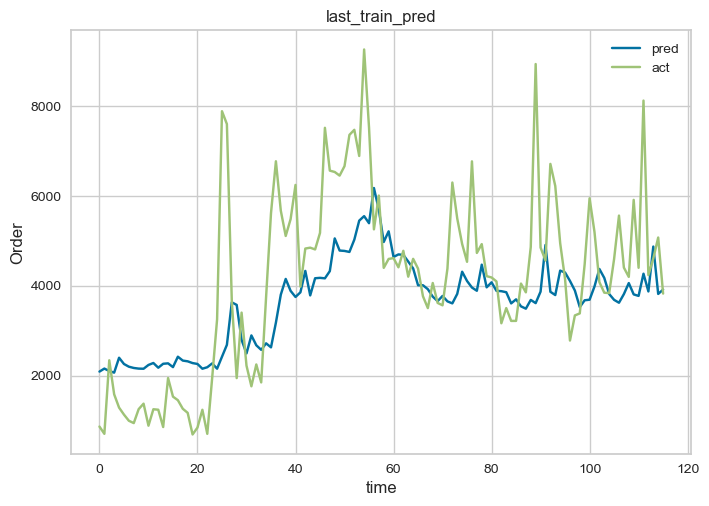

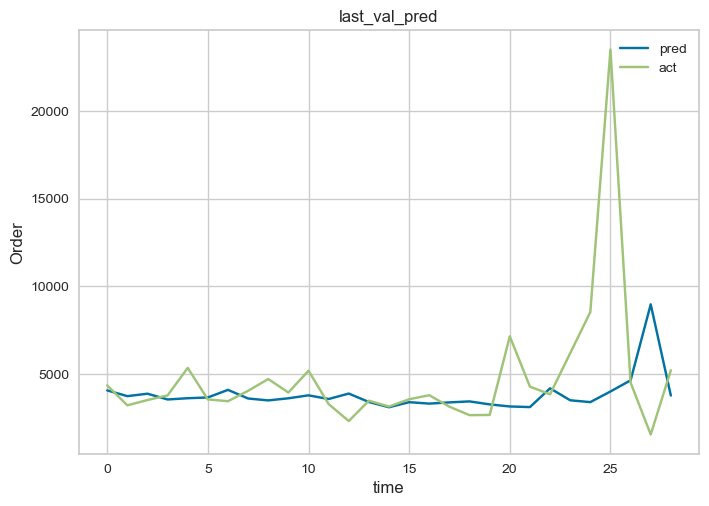

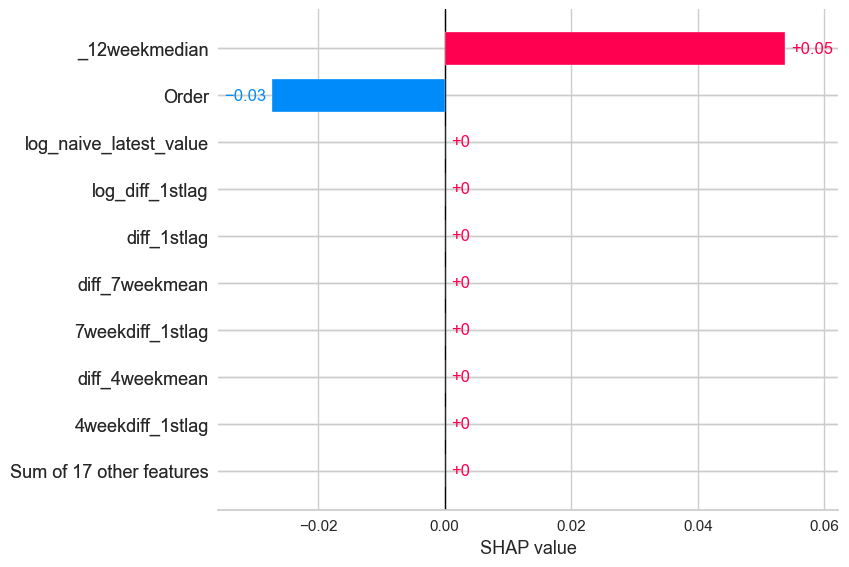

0.3835190631982426 0.38185939517456724


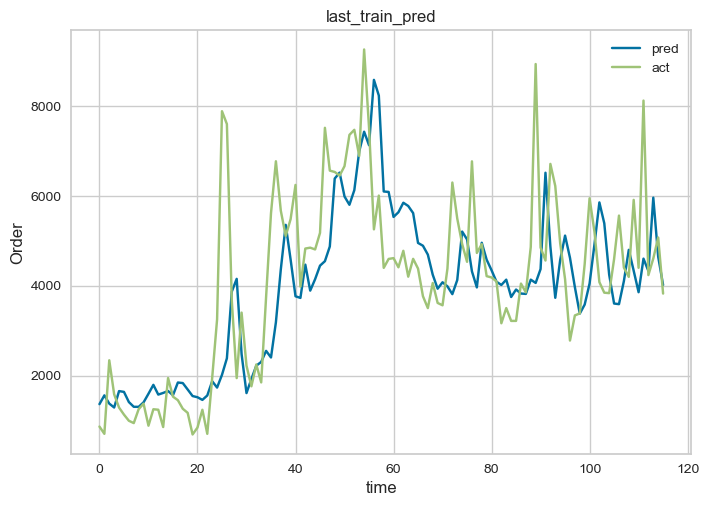

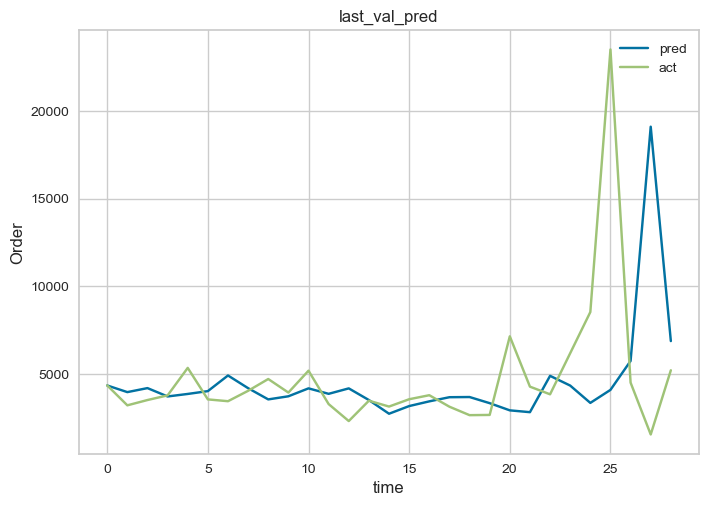

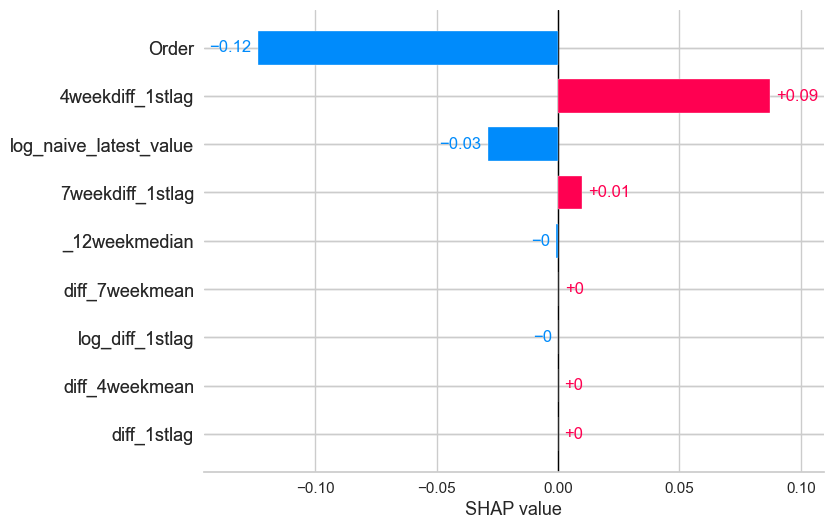

0.28134131758105 0.6461570770755454


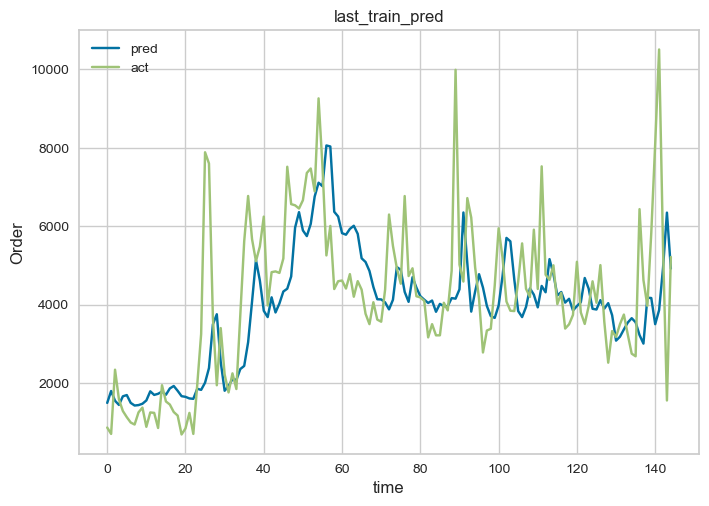

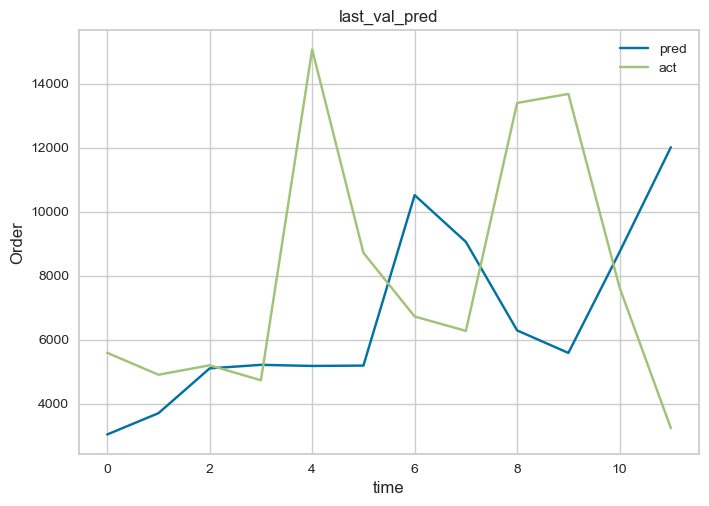

0.298988073191543 0.5730020720737716


In [17]:
# lasso,cross_val='sort'
y_train_pred, mape_train, y_val_pred, mape_val, top_9_feature_importance, best_model = ts.basic_model(pizza_X_train, pizza_y_train, pizza_X_val, pizza_y_val, pizza_X_test, pizza_y_test, pizza_X_train['Order']).lasso(log=True,cross_val='sort')
print(mape_train, mape_val)
y_train_pred, mape_train, y_val_pred, mape_val, top_9_feature_importance, best_model = ts.basic_model(pizza_X_train[top_9_feature_importance], pizza_y_train, pizza_X_val[top_9_feature_importance], pizza_y_val, pizza_X_test[top_9_feature_importance], pizza_y_test, pizza_X_train['Order']).lasso(log=True,cross_val='sort')
print(mape_train, mape_val)
y_train_pred, mape_train, y_val_pred, mape_val = ts.basic_model(last_pizza_X_train[top_9_feature_importance], last_pizza_y_train, last_pizza_X_test[top_9_feature_importance], pizza_y_test).last_train(best_model, a)
print(mape_train, mape_val)

result_dic['lasso_sort'] = mape_val
pred_dic['lasso_sort'] = y_val_pred
best_model_dic['lasso_sort'] = best_model

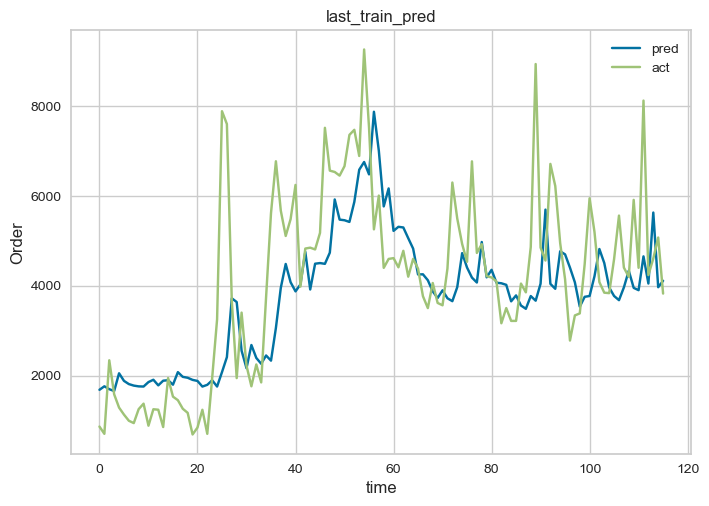

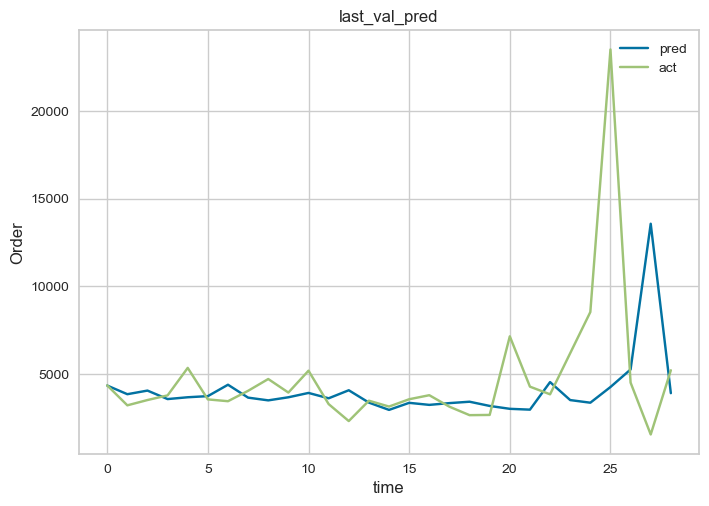

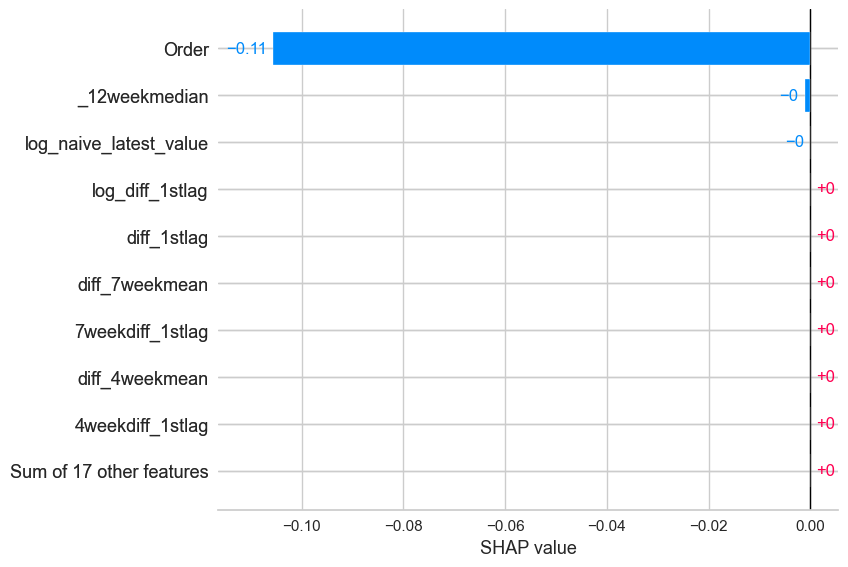

0.31504747045071446 0.49856937622208464


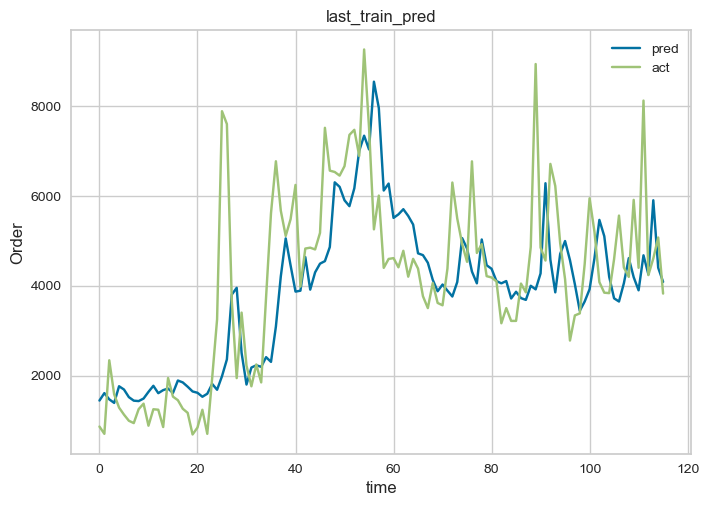

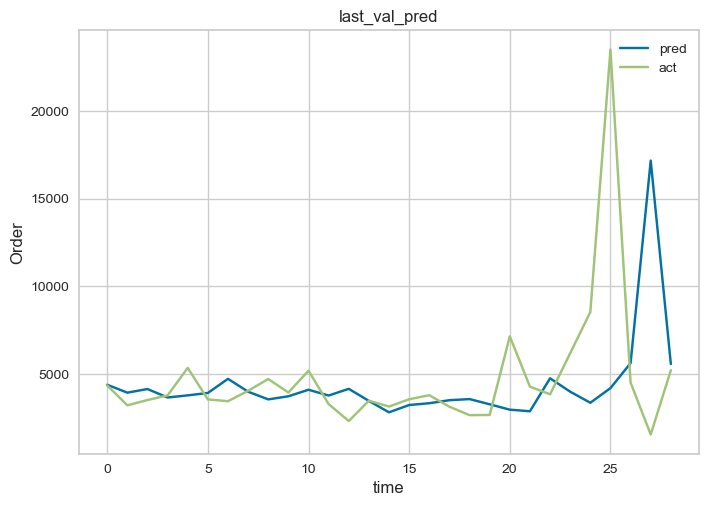

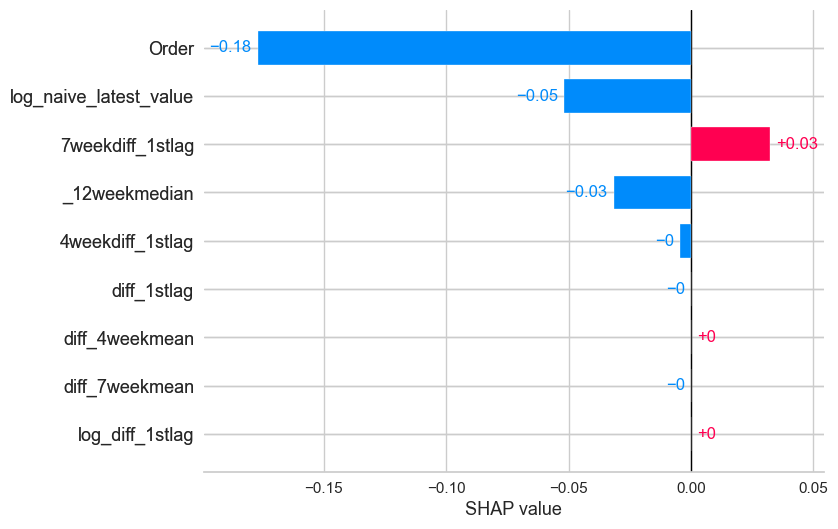

0.28653988260258006 0.5845127040748337


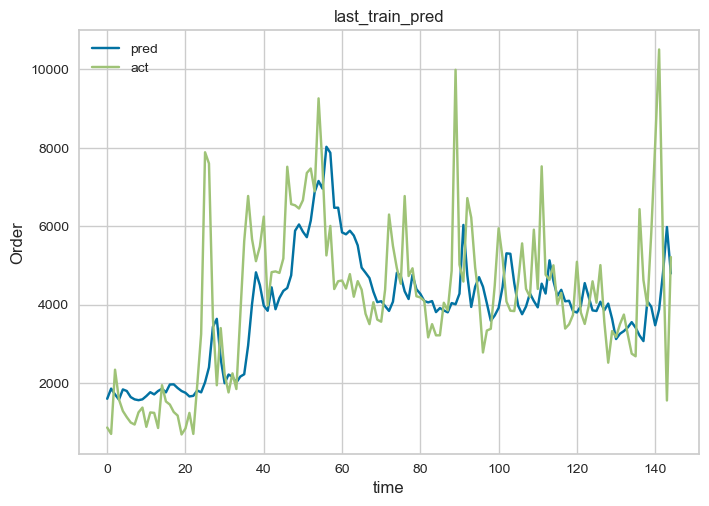

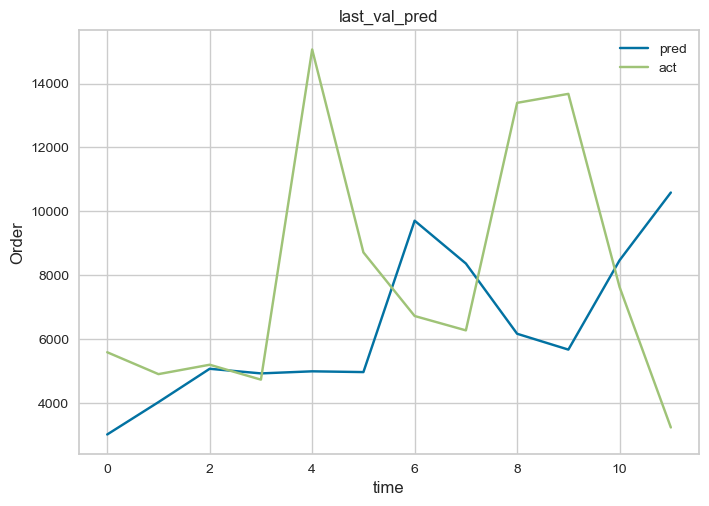

0.3035091412213233 0.507819623792395


In [18]:
# lasso,cross_val='accumulate'
y_train_pred, mape_train, y_val_pred, mape_val, top_9_feature_importance, best_model = ts.basic_model(pizza_X_train, pizza_y_train, pizza_X_val, pizza_y_val, pizza_X_test, pizza_y_test, pizza_X_train['Order']).lasso(log=True,cross_val='accumulate')
print(mape_train, mape_val)
y_train_pred, mape_train, y_val_pred, mape_val, top_9_feature_importance, best_model = ts.basic_model(pizza_X_train[top_9_feature_importance], pizza_y_train, pizza_X_val[top_9_feature_importance], pizza_y_val, pizza_X_test[top_9_feature_importance], pizza_y_test, pizza_X_train['Order']).lasso(log=True,cross_val='accumulate')
print(mape_train, mape_val)
y_train_pred, mape_train, y_val_pred, mape_val = ts.basic_model(last_pizza_X_train[top_9_feature_importance], last_pizza_y_train, last_pizza_X_test[top_9_feature_importance], pizza_y_test).last_train(best_model, a)
print(mape_train, mape_val)

result_dic['lasso_accumulate'] = mape_val
pred_dic['lasso_accumulate'] = y_val_pred
best_model_dic['lasso_accumulate'] = best_model

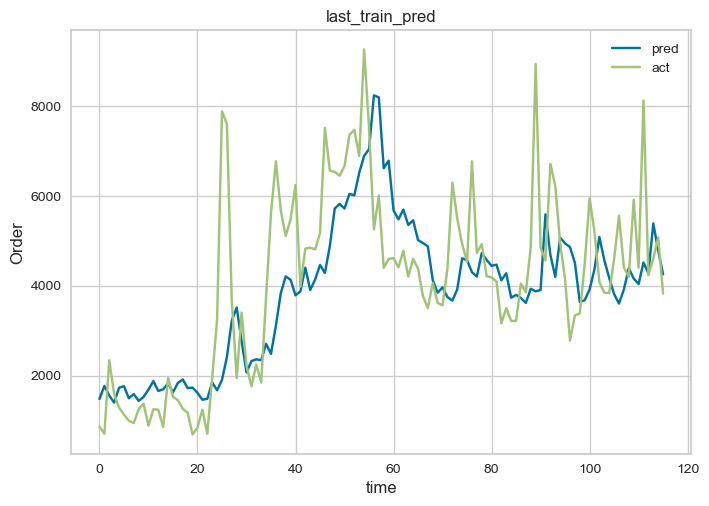

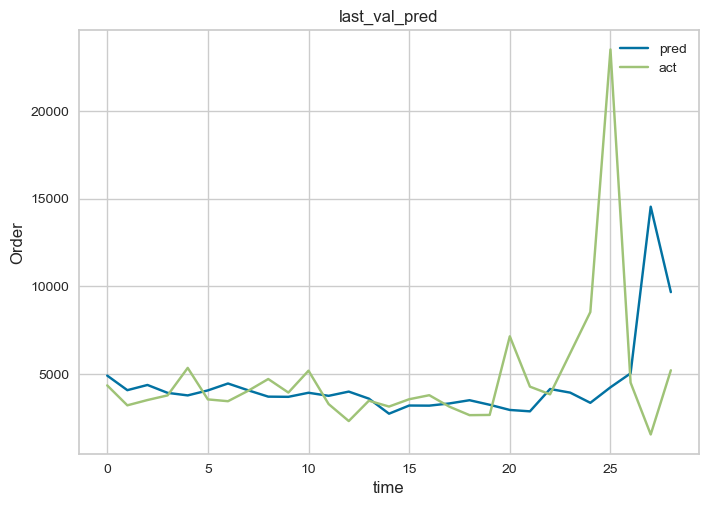

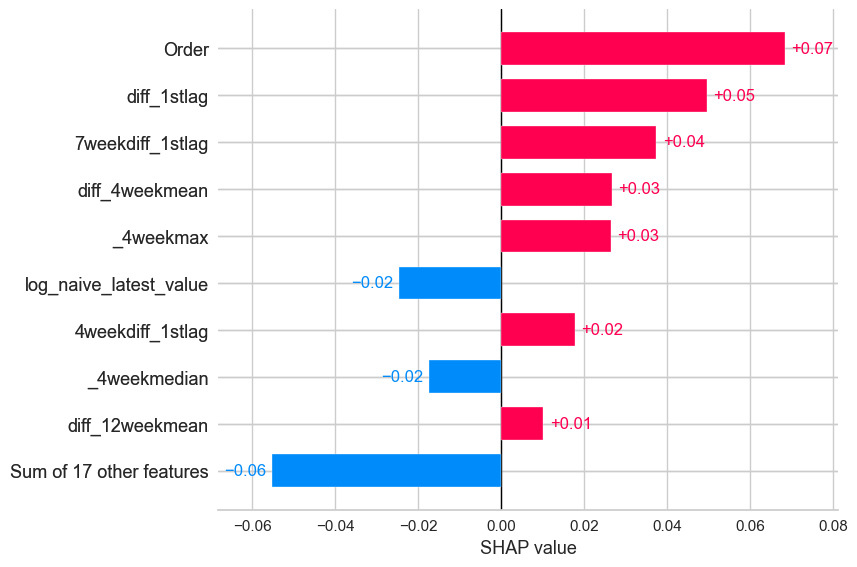

0.29781003623529934 0.5485428084870372


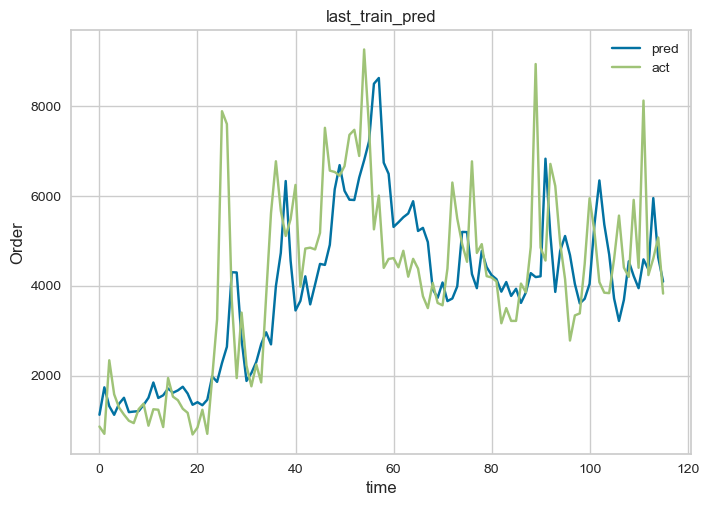

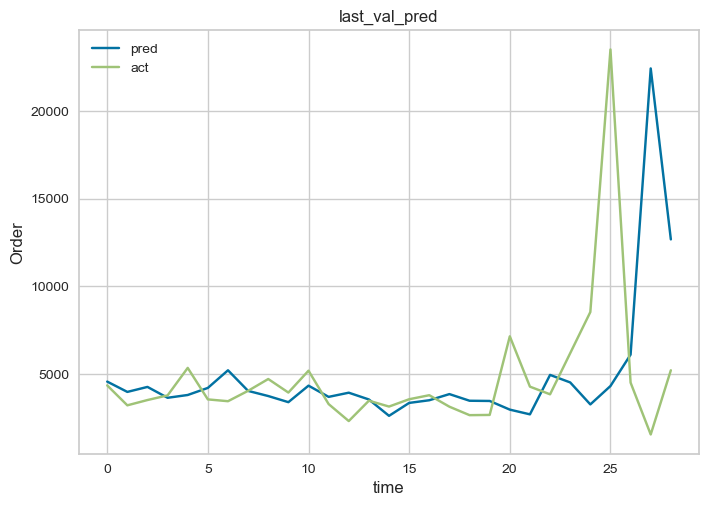

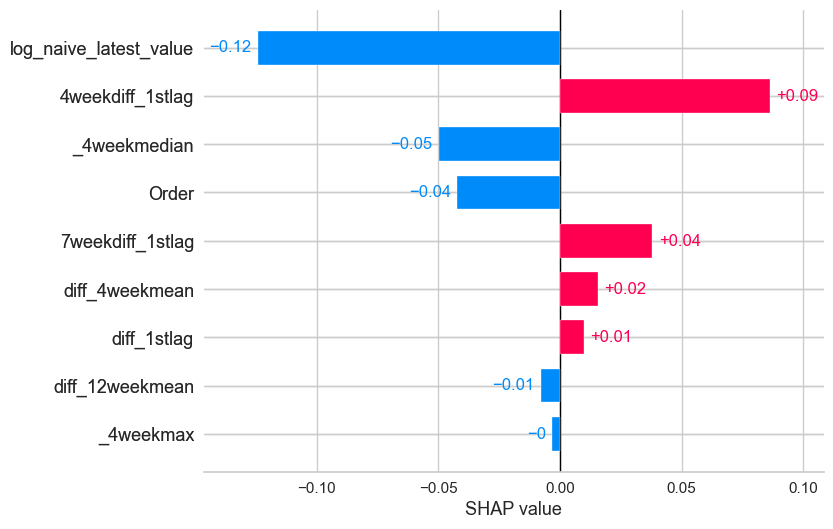

0.2771130540392292 0.7632967811152703


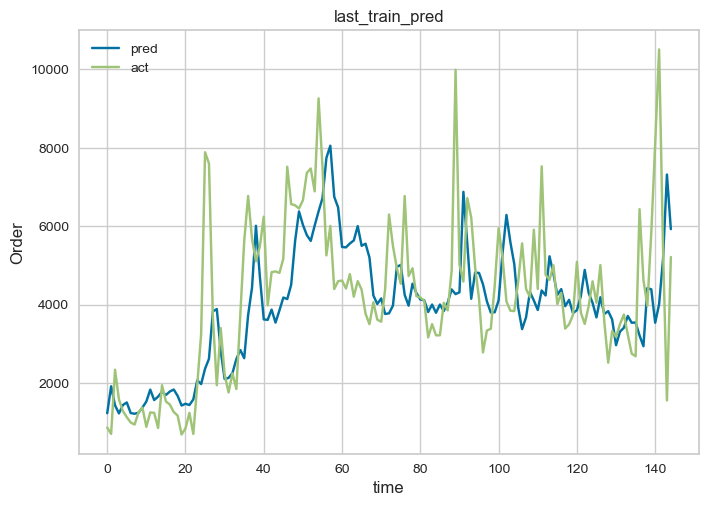

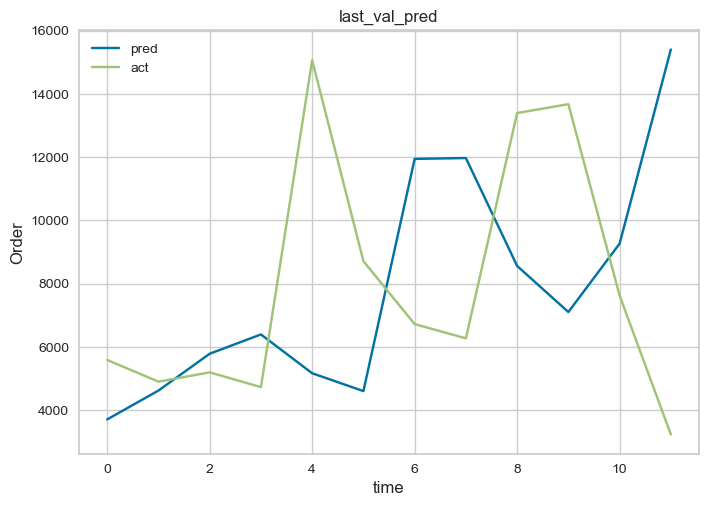

0.294557766913116 0.7082159585669955


In [19]:
# elasticnet,cross_val='accumulate'
y_train_pred, mape_train, y_val_pred, mape_val, top_9_feature_importance, best_model = ts.basic_model(pizza_X_train, pizza_y_train, pizza_X_val, pizza_y_val, pizza_X_test, pizza_y_test, pizza_X_train['Order']).elasticnet(log=True,cross_val='accumulate')
print(mape_train, mape_val)
y_train_pred, mape_train, y_val_pred, mape_val, top_9_feature_importance, best_model = ts.basic_model(pizza_X_train[top_9_feature_importance], pizza_y_train, pizza_X_val[top_9_feature_importance], pizza_y_val, pizza_X_test[top_9_feature_importance], pizza_y_test, pizza_X_train['Order']).elasticnet(log=True,cross_val='accumulate')
print(mape_train, mape_val)
y_train_pred, mape_train, y_val_pred, mape_val = ts.basic_model(last_pizza_X_train[top_9_feature_importance], last_pizza_y_train, last_pizza_X_test[top_9_feature_importance], pizza_y_test).last_train(best_model, a)
print(mape_train, mape_val)

result_dic['elasticnet_accumulate'] = mape_val
pred_dic['elasticnet_accumulate'] = y_val_pred
best_model_dic['elasticnet_accumulate'] = best_model

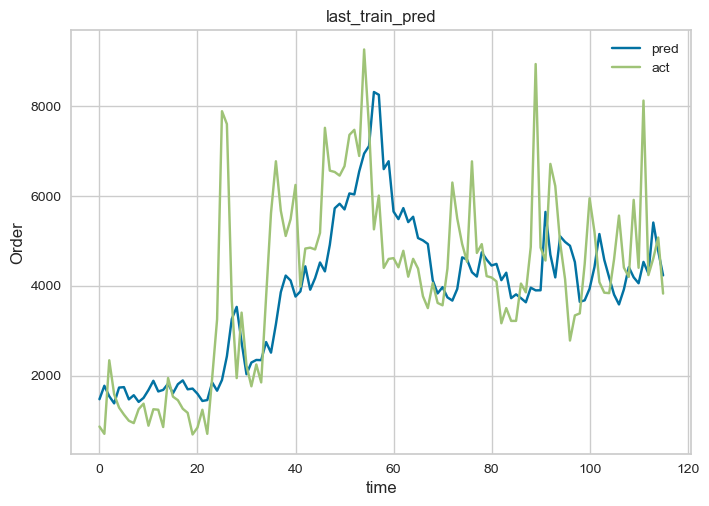

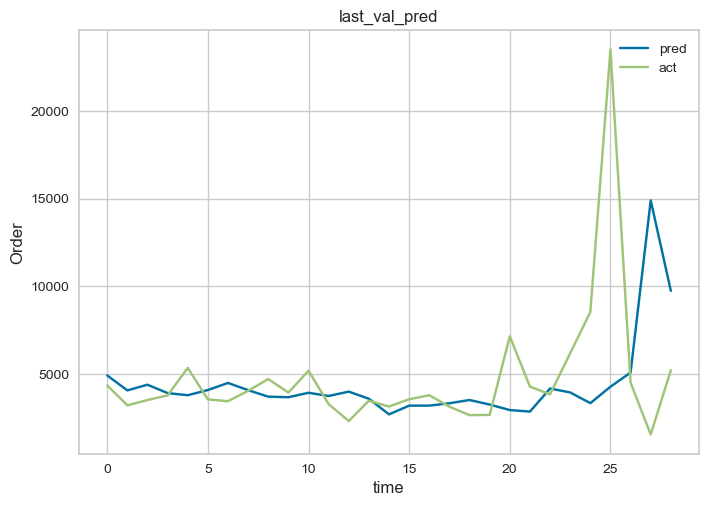

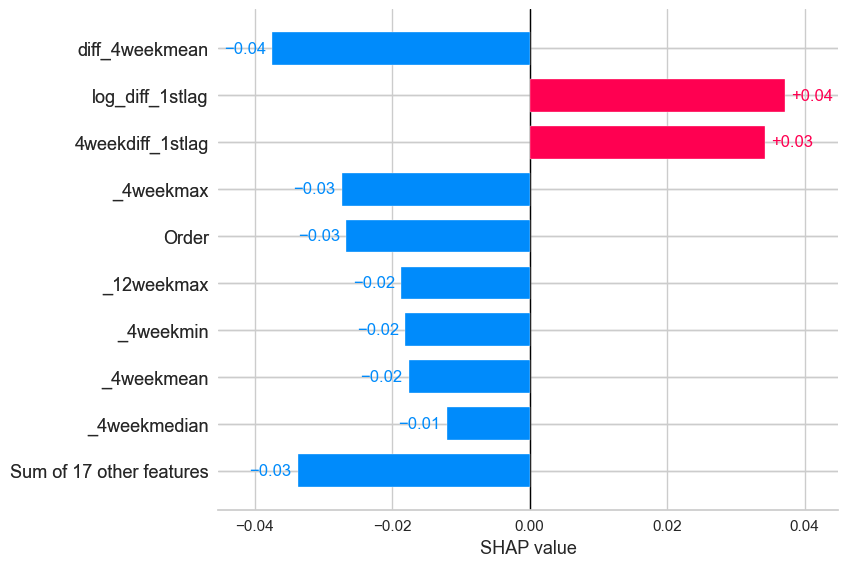

0.2957921480375446 0.5591162170569625


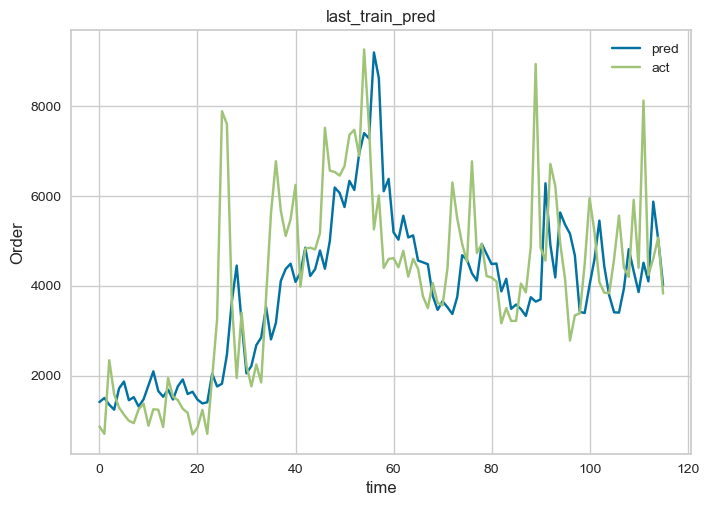

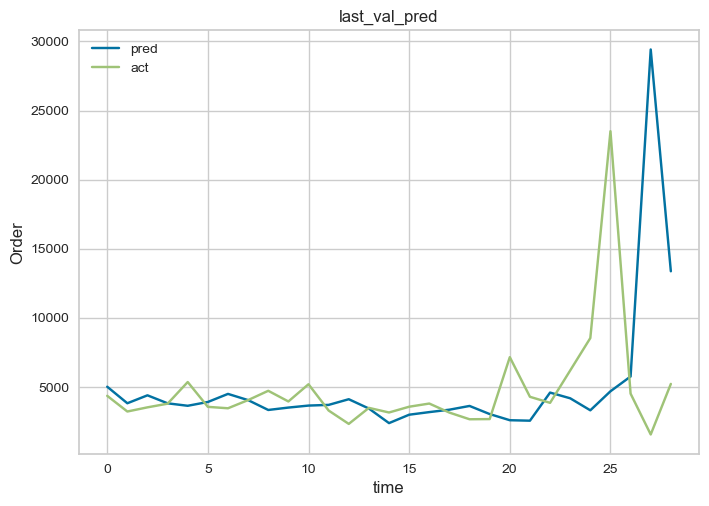

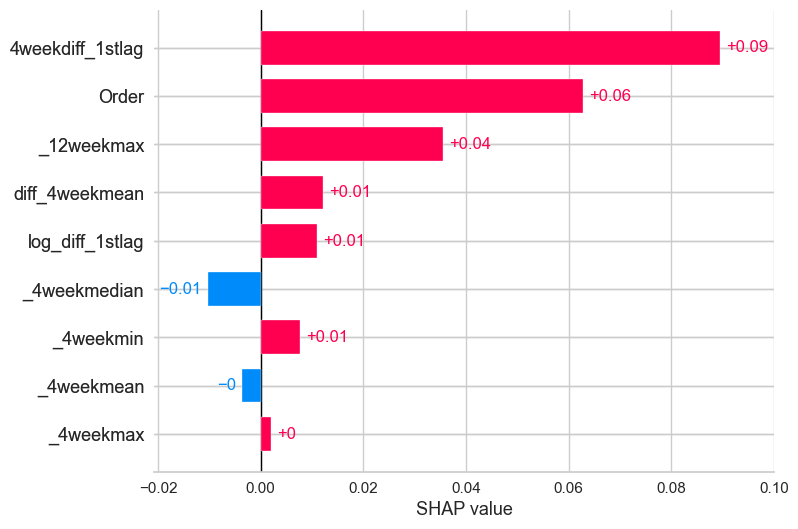

0.2864194048741603 0.9229292340374107


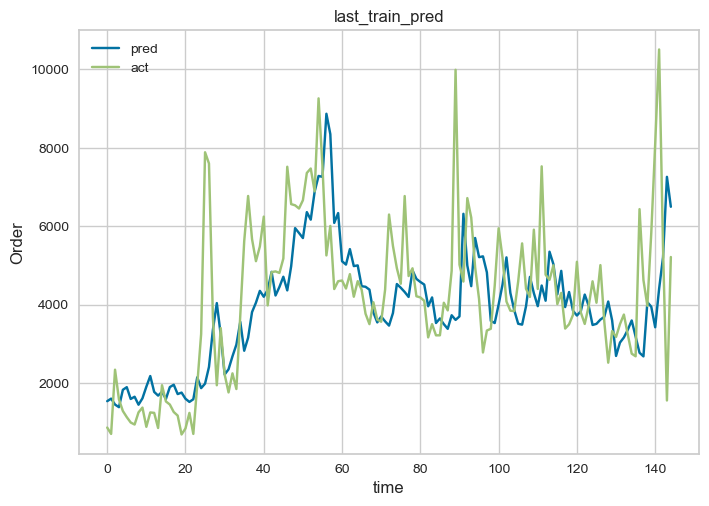

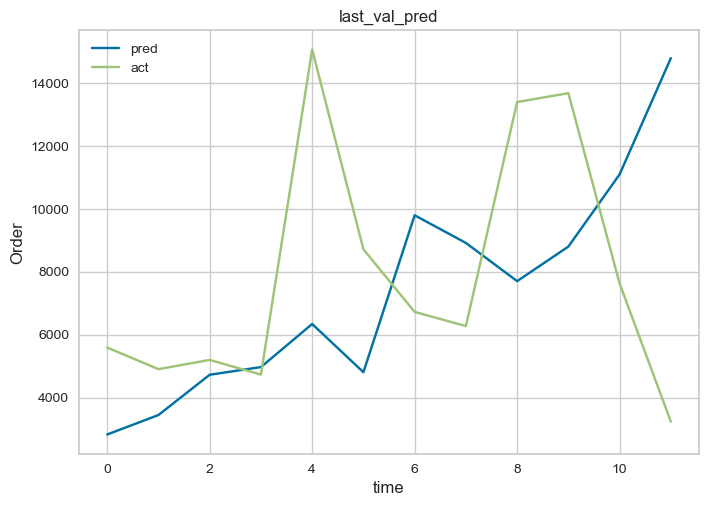

0.3103310556762975 0.637808484508528


In [20]:
# elasticnet,cross_val='sort'
y_train_pred, mape_train, y_val_pred, mape_val, top_9_feature_importance, best_model = ts.basic_model(pizza_X_train, pizza_y_train, pizza_X_val, pizza_y_val, pizza_X_test, pizza_y_test, pizza_X_train['Order']).elasticnet(log=True,cross_val='sort')
print(mape_train, mape_val)
y_train_pred, mape_train, y_val_pred, mape_val, top_9_feature_importance, best_model = ts.basic_model(pizza_X_train[top_9_feature_importance], pizza_y_train, pizza_X_val[top_9_feature_importance], pizza_y_val, pizza_X_test[top_9_feature_importance], pizza_y_test, pizza_X_train['Order']).elasticnet(log=True,cross_val='sort')
print(mape_train, mape_val)
y_train_pred, mape_train, y_val_pred, mape_val = ts.basic_model(last_pizza_X_train[top_9_feature_importance], last_pizza_y_train, last_pizza_X_test[top_9_feature_importance], pizza_y_test).last_train(best_model, a)
print(mape_train, mape_val)

result_dic['elasticnet_sort'] = mape_val
pred_dic['elasticnet_sort'] = y_val_pred
best_model_dic['elasticnet_sort'] = best_model

In [31]:
# 변수 중요도 x
result_dic['lstm'] = 0.29784667648319346
lstm_pred = np.array([[4587.727 ],
 [4902.    ],
 [5501.924 ],
 [6320.043 ],
 [9898.826 ],
 [5824.872 ],
 [4640.5   ],
 [4029.4722],
 [7169.028 ],
 [5617.4424],
 [4477.253 ],
 [3849.6118]])

pred_dic['lstm'] = np.array(list(pd.DataFrame(lstm_pred, columns=['y'])['y']))

In [32]:
result_dic

{'ma': 0.3018661469171053,
 'lgbm_sort': 0.38015768037104336,
 'lgbm_accumulate': 0.3876525780062862,
 'rf_sort': 0.3674569300641238,
 'rf_accumulate': 0.38013194543093537,
 'xgb_sort': 0.3684618120199679,
 'xgb_accumulate': 0.3487602028054118,
 'ridge_accumulate': 0.9174780837818027,
 'ridge_sort': 0.6317786032461072,
 'lasso_sort': 0.5730020720737716,
 'lasso_accumulate': 0.507819623792395,
 'elasticnet_accumulate': 0.7082159585669955,
 'elasticnet_sort': 0.637808484508528,
 'lstm': 0.29784667648319346}

In [33]:
pred_dic

{'ma': array([4942.73958404, 5201.37297829, 5497.95274766, 5311.64993632,
        5898.69997271, 6314.76214326, 6358.38516526, 6197.22183715,
        5913.64981797, 6486.12592408, 7404.33497776, 7114.80417654]),
 'lgbm_sort': array([2301.90807706, 3711.38237585, 4616.56515022, 4766.95552753,
        5267.29730368, 4644.79937647, 5417.04979555, 5333.95225162,
        4965.38405203, 4902.43649005, 4523.46521895, 4759.4314797 ]),
 'lgbm_accumulate': array([2254.19914553, 3871.83489288, 4360.48712951, 4636.72071434,
        4847.2721102 , 4769.64760076, 4935.62752429, 4991.79082174,
        4648.16677412, 4726.49572707, 4870.1939084 , 4509.16210956]),
 'rf_sort': array([2034.68425984, 4309.63135605, 4381.29706008, 4452.26224697,
        4850.4281836 , 5396.00942305, 4572.28995005, 5684.76746721,
        5933.02370813, 5665.1729287 , 4324.74633044, 4490.42941452]),
 'rf_accumulate': array([2031.49585381, 4007.62418526, 4089.21989536, 4127.63637351,
        5060.16969254, 5063.54854203, 5068

In [26]:
best_model_dic

{'lgbm_sort': LGBMRegressor(colsample_bytree=0.6023181230883761,
               learning_rate=0.12651506666852855, max_depth=12,
               min_child_samples=15, n_estimators=7433, num_leaves=17,
               reg_alpha=1.2912944739765324, reg_lambda=0.02329420878482867,
               subsample=0.15379943093686557),
 'lgbm_accumulate': LGBMRegressor(colsample_bytree=0.573207475186623,
               learning_rate=0.12012037755035815, max_depth=10,
               min_child_samples=16, num_leaves=25, reg_alpha=2.913305109177681,
               reg_lambda=1.0745690231974043, subsample=0.610166191245359),
 'rf_sort': RandomForestRegressor(max_depth=13, min_samples_leaf=5, min_samples_split=5,
                       n_estimators=66),
 'rf_accumulate': RandomForestRegressor(max_depth=3, min_samples_leaf=10, min_samples_split=16),
 'xgb_sort': XGBRegressor(alpha=0.002780011930452085, base_score=None, booster='dart',
              callbacks=None, colsample_bylevel=None, colsample_bynode=

In [27]:
# final model list
selected_keys = ['lstm']
model_scores = {key: result_dic[key] for key in selected_keys} # dictionary to save each model's score 

model_pred = {key: pred_dic[key] for key in selected_keys}

weights = {name: 1/mse for name, mse in model_scores.items()} # calculating a weighted average based on performance
total_weight = sum(weights.values())
weights = {name: weight/total_weight for name, weight in weights.items()}

# initializing prediction of ensemble 
ensemble_predictions = np.zeros(len(pizza_X_test))

# Ensemble by weighting the predictions of each model
for name, y_pred in model_pred.items():
    ensemble_predictions += weights[name] * y_pred

# Evaluation of the performance of ensemble predictions
ensemble_mse = ts.business_Metrics(a*0.1,0).ml_loss_mape(np.exp(pizza_y_test), ensemble_predictions)
print("앙상블 모델의 성능:", ensemble_mse)

앙상블 모델의 성능: 0.5046423802122272


In [28]:
ensemble_predictions

array([ 6012.17496313,  4392.9673    ,  8216.73796313, 10825.64696313,
       13232.596     ,  8545.595     , 10440.37796313, 14109.75396313,
        9596.184     ,  5860.55      ,  6908.7285    ,  6825.87096313])

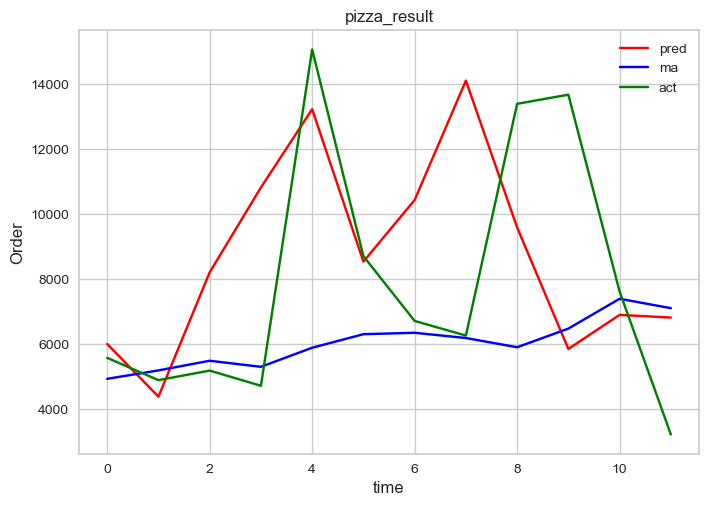

In [29]:
# graph 
plt.plot(np.exp(pizza_y_test).index, ensemble_predictions, label='pred', color= 'red')
plt.plot(np.exp(pizza_y_test).index, pred_dic['ma'], label='ma' ,color= 'blue')
plt.plot(np.exp(pizza_y_test).index, np.exp(pizza_y_test), label='act', color= 'green')

plt.title('pizza_result')
plt.legend()

plt.xlabel('time')
plt.ylabel('Order')

plt.show()

In [30]:
pd.DataFrame(pred_dic['ma']).to_csv('pizza_ma.csv')
pd.DataFrame(ensemble_predictions).to_csv('pizza_pred.csv')
pd.DataFrame(np.exp(pizza_y_test)).to_csv('pizza_test.csv')